<font size=5> **Plotting sea ice in the Southern Ocean** </font>  
  
This script produces plots of sea ice area around the Southern Ocean using outputs from ACCESS-OM2-01. Comparison with observations is done using NASA Goddard passive microwave sea ice concentration data.  
  
**Requirements:** It is suggested you use the `conda/analysis3-20.07` (or later). This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a code cell.

# Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import os
from glob import glob
import re
from collections import OrderedDict
# from datetime import datetime
import calendar
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf
import netCDF4 as nc
import datetime as dt
import cftime
import xesmf as xe
import rioxarray
from itertools import cycle
import string

The following modules are used in plotting maps and time series.

In [2]:
#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import matplotlib.cm as mcm
import geopandas

#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# Accessing ACCESS-OM2-01 outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 8)

## Set up variable dictionary prior ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [4]:
varDict =  {'var_id': 'aice_m',
            'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 monthly',
             'start_date': range(1965, 2018, 1),
             'offset': np.nan,
             'long_name': 'sea ice area',
             'short_name': 'SIA',
             'unit': '$m^2$',
             'CICE_data': True,
             'base_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/Data',
             'climatologies': r'/g/data/v45/la6889/Calculations/SeaIceArea/Climatologies',
             'clim_fig': r'/g/data/v45/la6889/Figures/SeaIceArea/Climatologies',
             'linear_trends': r'/g/data/v45/la6889/Calculations/SeaIceArea/LinearTrends',
             'lm_fig': r'/g/data/v45/la6889/Figures/SeaIceArea/LinearTrends',
             'clipped_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/ClippedMEASOregions/',
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlyMonthly/Means',
             'weighted_std_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlyMonthly/StdDev',
             'decades': range(1965, 2019, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/SeaIceArea/DecadalSeasonal/Means',
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/SeaIceArea/TimeSeries/MEASO',
             'res': '0.1°'}

## Finding experiment variable names (Optional step)
You can query the temporal frequency of all variables available in the experiment using `cc.querying.get_frequencies(session, experiment)`. A list of experiment variables can be obtained using `cc.querying.get_variables(session, experiment, frequency)`.

Access the default database of experiments from where data will be loaded.

In [5]:
session = cc.database.create_session()

This notebook uses the outputs for the v140 run of ACCESS-OM2-01 which includes wind forcing. Includes experiments `01deg_jra55v140_iaf` and `01deg_jra55v140_iaf`. A list of experiments can be accessed using `cc.querying.get_experiments(session)`, you can get a detailed list of experiments by adding `all = True` argument.

In [4]:
#Activate the lines below to query temporal frequency
cc.querying.get_frequencies(session, varDict['expt'])

,frequency
0,None
1,1 daily
2,1 monthly
3,static


Query experiment variables list

In [15]:
#Querying experiment variables
expvar = cc.querying.get_variables(session, varDict['expt'], frequency = varDict['freq'])

#Extract variables with keywords included in its long_name column
expvar[expvar["long_name"].str.lower().str.match(".*ice.*")] #force all letters to be lowercase to get matches

In [ ]:
#Deleting variables no longer in use
del expvar

## Accessing ACCESS-OM2 outputs and saving results to disk

In [7]:
dir_out = varDict['base_data']
os.makedirs(dir_out, exist_ok = True)

for yr in varDict['decades']:
    #Accessing data per decade
    stime = f'{str(yr)}-01'
    etime = f'{str(yr+9)}-12'
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata(varDict['var_id'], stime, etime,
                           freq = varDict['freq'], 
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = True)
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Creating name of file    
    fn = f'SeaIceConcentration_{str(yr)}-{str(yr+9)}.nc'
    #Saving file
    SO.to_netcdf(os.path.join(dir_out, fn))

### Loading longitude corrected sea ice concentration data from disk

In [5]:
#Get list of files in disk
filelist = sorted(glob(os.path.join(varDict['base_data'], '*Conc*.nc')))

#Empty list to store files
SIC = []

#Loading single files
for file in filelist:
    SIC.append(xr.open_dataarray(file))

#Concantenating all files into a single data array
SIC = xr.concat(SIC, dim = 'time')

# Loading MEASO regions to overlay them on plots

<AxesSubplot:>

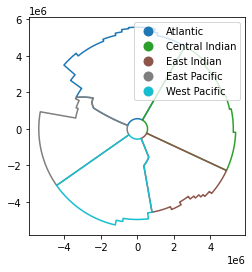

In [6]:
#Load shapefile
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Get sector names from shapefile
sectors = np.unique(MEASO.sector)

#Merge sectors within regions as sea ice is mostly within Antarctic areas
for i, sec in enumerate(sectors):
    pol = MEASO.query(f'sector == "{sec}"').geometry.unary_union
    pol_gs = geopandas.GeoSeries(pol).exterior
    if i == 0:
        MEASO_fixed = pol_gs
    else:
        MEASO_fixed = MEASO_fixed.append(pol_gs)

#Transforming geoseries into geodataframe to add region names
#and adding a new column with the names of the sectors
MEASO_fixed = geopandas.GeoDataFrame(geometry = MEASO_fixed).\
assign(sector = sectors)
        
#Checking results
MEASO_fixed.plot(column = 'sector', legend = True)

# Calculating climatologies for variable of interest across the Southern Ocean
The satellite period (1979-2008) was chosen to calculate climatologies, and three climatologies were calculated:
- Overall, which includes the mean for the entire climatological period
- Seasonal, which is the mean value per season over the climatological period
- Monthly, which is the mean monthly value over the climatological period

Calculations are done in this way to avoid issues with memory.

In [20]:
clim_overall = zsf.climCalc(SIC, [1979, 2018], clim_type = 'overall', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])
clim_seasonal = zsf.climCalc(SIC, [1979, 2018], clim_type = 'seasonal', 
                             varname = varDict['short_name'],
                             folder_out = varDict['climatologies'])
clim_monthly = zsf.climCalc(SIC, [1979, 2018], clim_type = 'monthly', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])

## Loading climatologies and plotting them

### Overall Climatology

In [ ]:
folder = os.path.join(varDict['climatologies'], '*overall*.nc')
fn = glob(folder)[0]

clim_overall = xr.open_dataarray(fn)*100

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

levels = np.arange(0, 101, 5)

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

ax = fig.add_subplot(111, projection = projection)

#Add contour plot of sea ice advance
p = clim_overall.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', levels = levels,
                                 ax = ax, cmap = cm.cm.ice, 
                                transform = ccrs.PlateCarree(), 
                                add_colorbar = False)

#Add land and coastlines
ax.add_feature(land_50m)
ax.coastlines(resolution = '50m')

#Apply colourbar to figure and set it to be horizontal
cb = fig.colorbar(p, ax = ax, label = 'Sea Ice Concentration (%)', pad = 0.1)

#Add title
ax.set_title('Climatology ' + varDict['long_name'].title() + '(1979-2008)')

#Draw gridlines
gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
#Locate longitude ticks - Set to every 30 deg
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#Give longitude labels the correct format for longitudes
gl.xformatter = LONGITUDE_FORMATTER
#Set rotation of longitude labels to zero
gl.xlabel_style = {'rotation': 0}
#Set latitude labels to be transparent
gl.ylabel_style = {'alpha': 0}
#Add space between axis ticks and labels for x and y axes
gl.xpadding = 9
gl.ypadding = 9
gl.xlabels_left = False
gl.xlabels_right = True
gl.xlabels_top = False

#Remove the outside frame and ticklines of the figure
[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_xticklines()]
[t.set_visible(False) for t in ax.get_yticklines()]

fn = 'OverallClimatology_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Seasonal Climatology

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '



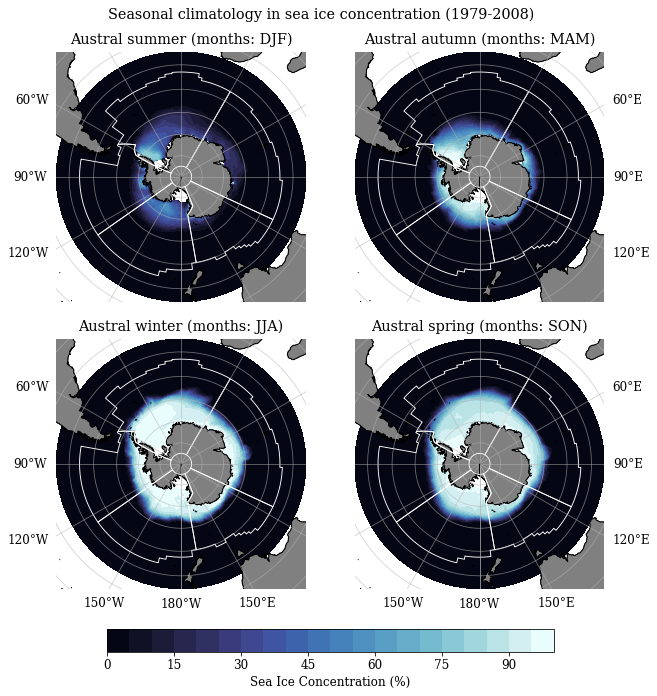

In [22]:
#Loading climatology
folder = os.path.join(varDict['climatologies'], '*seasonal*.nc')
fn = glob(folder)[0]

clim_seasonal = xr.open_dataarray(fn)*100

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

levels = np.arange(0, 101, 5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 
              'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    p1 = (clim_seasonal.sel(season = season)).\
    plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                  cmap = cm.cm.ice, levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    MEASO_fixed.plot(color = 'white', lw = 0.9, ax = ax[season])
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season] + ' (months: ' + season + ')', y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.8, pad = 0.06, 
                  label = 'Sea Ice Concentration (%)')
    
fig.suptitle('Seasonal climatology in sea ice concentration (1979-2008)', 
             y = 0.93)

fn = 'SeasonalClimatology_SeaIceConcentration_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Monthly Climatology

In [ ]:
folder = os.path.join(varDict['climatologies'], '*month*.nc')
fn = glob(folder)[0]

clim_monthly = xr.open_dataarray(fn)*100

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (15, 15))

levels = np.arange(0, 101, 5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 3, ncols = 4)
#Change the width between each plot
gs.update(wspace = 0.12, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for n, m in enumerate(clim_monthly.month.values):
    ax[m] = fig.add_subplot(gs[n], projection = projection)
    #Extract information for each season and start plotting
    p1 = (clim_monthly.sel(month = m)).\
    plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = ax[m], 
                  cmap = cm.cm.ice, levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
        
    #Set title for each subplot.
    ax[m].set_title(calendar.month_name[m], y = 1.01)
    #Remove x and y axes labels
    ax[m].set_ylabel("")
    ax[m].set_xlabel("")
      
    #Add land and coastlines
    ax[m].add_feature(land_50m)
    ax[m].coastlines(resolution = '50m')
        
    #Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
    if n not in [8, 9, 10, 11]:
        cb = fig.colorbar(p1, ax = ax[m], orientation = 'horizontal', 
                          shrink = 0.97, pad = 0.05, 
                          label = 'Sea Ice Concentration (%)')
    else:
        cb = fig.colorbar(p1, ax = ax[m], orientation = 'horizontal', 
                          shrink = 0.97, pad = 0.09, 
                          label = 'Sea Ice Concentration (%)')

    #Draw gridlines
    gl = ax[m].gridlines(draw_labels = True, y_inline = False, 
                         color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    gl.xlabels_left = False
    gl.xlabels_right = False
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if n in [0, 4]:
        gl.ylabels_left = True
    elif n in [3, 7]:
        gl.ylabels_right = True
    elif n == 8:
        gl.ylabels_left = True
        gl.xlabels_bottom = True
    elif n in [9, 10]:
        gl.xlabels_bottom = True
    elif n == 11:
        gl.ylabels_right = True
        gl.xlabels_bottom = True
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[m].spines.values()]
    [t.set_visible(False) for t in ax[m].get_xticklines()]
    [t.set_visible(False) for t in ax[m].get_yticklines()]

fig.suptitle('Monthly climatology ' + varDict['long_name'].title() + ' (1979-2008)', 
             y = 0.93)

fn = 'MonthlyClimatology_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating linear trends in sea ice concentration
SIC less than 0.1 were removed because the algorithm by NASA considers pixels with SIC estimates less than 0.1 as open water (see page 30 of [User Guide](https://nsidc.org/data/g02202/versions/3)).

## Defining seasons

In [7]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

## Separating data into seasons
NA values are transformed to zeros (0) prior to calculating mean values of SIC.

In [8]:
#Selecting SIC data for time period of interest and removing pixels values < 0.1
climdata = SIC.sel(time = slice('1978-12', '2018-11')).\
where(SIC >= 0.1).fillna(0)

seasons_SIC = {}

for season in seasonName.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(climdata[i])
    seasons_SIC[season] = xr.concat(y, dim = 'time')

## Calculating linear trends for model data

In [43]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Empty dictionary to store results
LM_results = {}

#Calculating linear trend for each season
for season in seasons_SIC:
    #Define file name
    fn = f'LinearTrend_SIC_{season}_1979-2018.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIC[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIC[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "std_err")

    LM_results[season] = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results[season].to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends to avoid recalculating

In [9]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Linear*.nc'))

LM_results = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

### Plotting linear trends per for model data
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.  
**Non-significant trends have been blanked out**  
Non-significant refers to areas where the absolute value of the trend is less than the standard error.

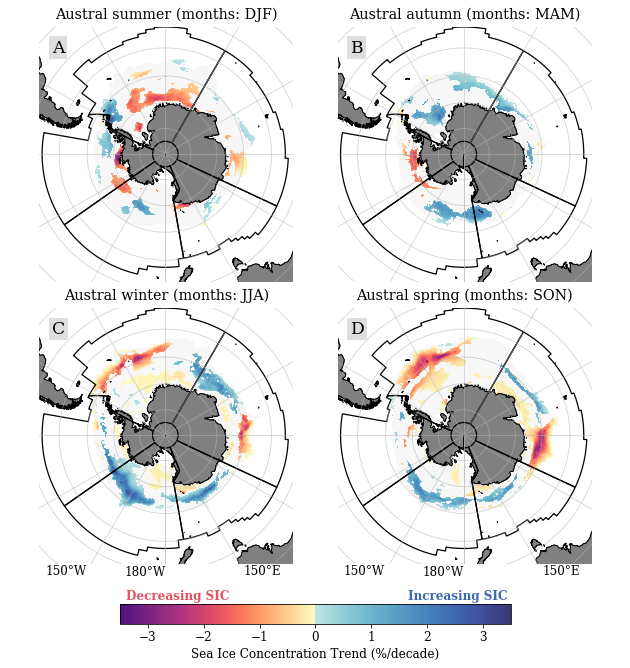

In [49]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Colormap settings
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -3.5, vcenter = 0, vmax = 3.5)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
mymap.set_bad('white')

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_results[season].coefficients
    #Standard errors
    se = LM_results[season].std_err
    
    #Create mask to cover non-significant trends (i.e., absolute trends less than std error
    #of trend)
    mask = xr.where(np.fabs(data) < se, 1, np.nan) 
    
    #Multiplying by 1000 to get percentages per decade
    p1 = (data*1000).where(data != 0).\
    plot.pcolormesh(ax = ax[season], cmap = mymap, 
                    transform = ccrs.PlateCarree(),
                    norm = divnorm, add_colorbar = False)
    #Apply mask
    mask.plot.contourf(colors = '#f7f7f7', ax = ax[season],
                       transform = ccrs.PlateCarree(), 
                       add_colorbar = False)
    
    #Plot MEASO regions
    MEASO_fixed.plot(color = 'black', lw = 1.25, ax = ax[season])
    
    #Set title for each subplot.
    ax[season].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Sea Ice Concentration Trend (%/decade)')

#Add labels to improve readability
#Get colormap to extract colors for labels
cb.ax.text(1.65, 1.25, 'Increasing SIC', color = mymap(0.85), fontweight = 'bold')
cb.ax.text(-3.4, 1.25, 'Decreasing SIC', color = mymap(0.25), fontweight = 'bold')

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:4]

#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.05, .9, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

# fig.suptitle('Seasonal linear trends in sea ice concentration (SIC) from model outputs (1979-2008)', 
#              y = 0.93)

# fn = 'SeasonalLinearTrends_NonSigHatched_SeaIceConcentration_1979-2008.png'
fn = 'SeasonalLinearTrends_SeaIceConcentration_1979-2018_NoTitle.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

### Calculating standard deviation

In [56]:
#Folder where std dev will be saved
file_out = varDict['linear_trends']
os.makedirs(file_out, exist_ok = True)

#Empty dictionary where results will be stored
std_season = {}

#Calculating standard deviation
for season in seasons_SIC:
    std_season[season] = seasons_SIC[season].std('time')
    #Creating file name to store outputs
    fn = f'StdDev_SIC_{season}_1979-2018.nc'
    std_season[season].to_netcdf(os.path.join(file_out, fn))

### Loading standard deviation to avoid recalculating

In [23]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Std*2018.nc'))

#Empty dictionary where results will be stored
std_season = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    std_season[season] = xr.open_dataarray(file[0])

### Plotting SIC standard deviation

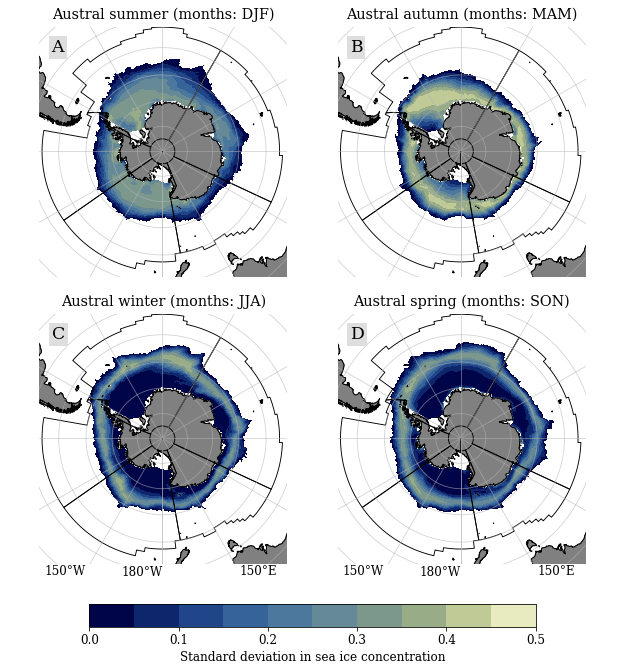

In [58]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))
levels = np.arange(0, 0.51, 0.05)

#Colormap from Scientific Colour Map package
davos = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = False)
#Shortening colormap to remove white
davos_short = mcolors.LinearSegmentedColormap.from_list('davos_short',
                                                        davos(np.linspace(0, .85, 128)))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    p1 = std_season[season].sel(yt_ocean = slice(-90, -50)).plot.\
    pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                  cmap = davos_short, levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    xr.where(std_season[season] == 0, 1, np.nan).plot.\
    contourf(ax = ax[season], transform = ccrs.PlateCarree(), cmap = 'white',
             add_colorbar = False)
                                                               
    MEASO_fixed.plot(color = 'black', lw = 0.9, ax = ax[season])
    
    #Set title for each subplot.
    ax[season].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.8, pad = 0.06, 
                  label = 'Standard deviation in sea ice concentration')

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:4]

#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.05, .9, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))
    
# fig.suptitle('Standard deviation in sea ice concentration (1979-2008)', 
#              y = 0.93)

# fn = 'StdDev_SeaIceConcentration_1979-2008.png'
fn = 'StdDev_SeaIceConcentration_1979-2018_NoTitle.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight',
            pad_inches = 0.05)

## Loading observations

In [59]:
#Location of observation files
filelist = sorted(glob('/g/data/v45/la6889/Observations/*.nc'))

#Load them as data array
iceObs = []
for yr in range(1978, 2019):
    file = [f for f in filelist if str(yr) in f]
    data = xr.open_dataarray(file[0]).groupby('time.month').mean('time')
    time = pd.date_range(f'{yr}-{data.month.values.min()}', 
                         f'{yr}-{data.month.values.max()}', freq = 'MS')
    data = data.rename({'month': 'time'})
    data['time'] = time
    iceObs.append(data)
iceObs = xr.concat(iceObs, dim = 'time').sel(time = slice('1978-12', '2018-11'))

#Divide them into seasons
seasons_SIC_obs = {}
for season in seasonName.keys():
    y = []
    for i, m in enumerate(iceObs.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(iceObs[i])
    seasons_SIC_obs[season] = xr.concat(y, dim = 'time')

## Comparing SIC from model and observations

### Regridding of model outputs to match observations (coarsening data) and calculating SIC differences
When plotting the regridded model outputs, the y axis must be inverted for the map to show the right way up. This can be done by adding the following line after plotting: `plt.gca().invert_yaxis()`.

In [63]:
#Rename coordinates in observation based and model based SIC
#Empty list to store renamed model data
mod = {}
obs = {}

#Rename coordinates to match observations
for key in seasons_SIC:
    #Cropping model outputs between 50S and 90S
    mod[key] = seasons_SIC[key].rename({'xt_ocean': 'lon', 
                                       'yt_ocean': 'lat'}).\
    sel(lat = slice(-90, -50))
    #Renaming coordinates from observations prior to regridding
    obs[key] = seasons_SIC_obs[key].\
    rename({'longitude': 'lon', 'latitude': 'lat'})

In [64]:
#Regridder only calculated once as the same will be applied for all seasons
reg_coarse = xe.Regridder(mod[key], obs[key], 'bilinear')

#Ensuring folder to save regridded data exists
folder_out = os.path.join(varDict['base_data'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)

#Empty list to store regridded model data, climatologies and biases
seasonal_clim_mod = {}
seasonal_clim_obs = {}
clim_dif = {}
reg_mod = {}

#Apply regridder
for key in mod:
    reg_mod[key] = reg_coarse(mod[key])
    reg_mod[key]['ygrid'] = obs[key].ygrid
    reg_mod[key]['xgrid'] = obs[key].xgrid
    fn = f'SIC_regridded-mod_{key}_1979-2018.nc'
    reg_mod[key].to_netcdf(os.path.join(folder_out, fn))
    #Calculate seasonal climatologies SIC and transform to percentages
    seasonal_clim_mod[key] = reg_mod[key].mean('time')*100
    seasonal_clim_obs[key] = obs[key].mean('time')*100
    #Calculate differences in SIC
    clim_dif[key] = seasonal_clim_mod[key]-seasonal_clim_obs[key]

### Plotting differences in SIC

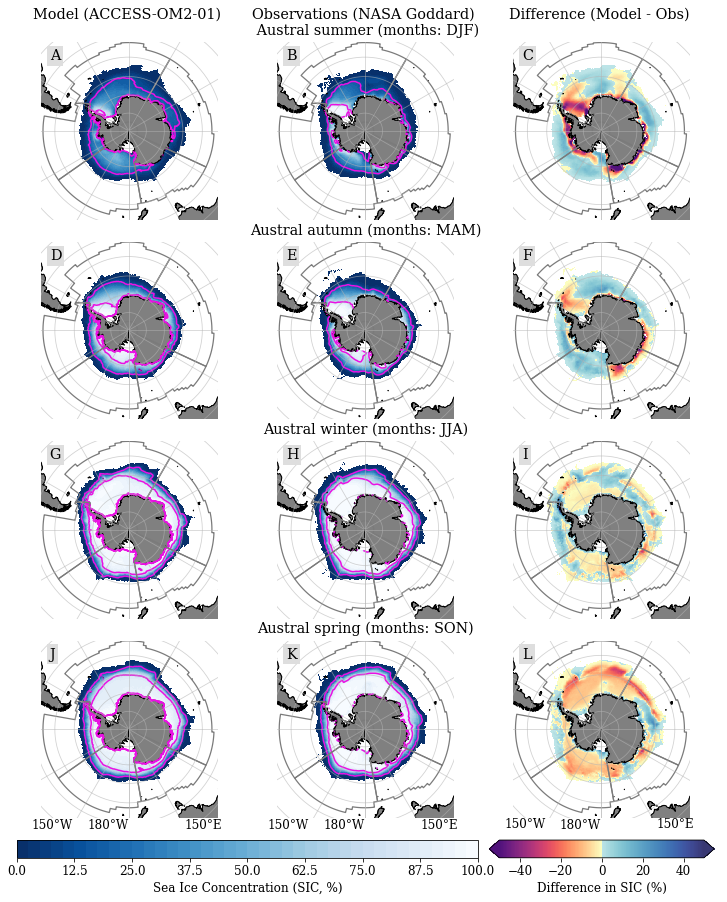

In [91]:
folder = os.path.join(varDict['climatologies'], '*seasonal*.nc')
fn = glob(folder)[0]

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 15))

#######
###Colorbar settings
#Levels for colorbar
SIC_levels = np.arange(0, 101, 2.5)

#Create colormap for differences
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#Set NA values to show as white
mymap.set_bad('white')
#######

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Defining datasets to be plotted
data = ['Model (ACCESS-OM2-01)', 
        'Observations (NASA Goddard)', 
        'Difference (Model - Obs)']
#Merge seasons and datasets
counter = zip(cycle(data), np.repeat(list(seasonName), len(data)))

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = len(seasonName)+1, 
                       ncols = len(data),
                       height_ratios = (1, 1, 1, 1, 0.1))
#Change the width between each plot
gs.update(wspace = 0.05, hspace = 0.15)

ax = {}

#Creating plot using loops
for i, coord in enumerate(counter):   
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    #Model data
    if 'ACCESS' in coord[0]:
        da = seasons_SIC[coord[1]].mean('time')*100
        p1 = da.where(da != 0).plot.\
        pcolormesh(ax = ax[i], cmap = plt.cm.Blues_r, 
                   levels = SIC_levels, transform = ccrs.PlateCarree(),
                   add_colorbar = False)
        
        #Adding MIZ limits
        da.plot.contour(levels = [15, 80], 
                        transform = ccrs.PlateCarree(),
                        ax = ax[i], colors = '#ea11e3')
    #Observational data
    elif 'NASA' in coord[0]:
        da_o = seasons_SIC_obs[coord[1]].mean('time')*100
        p1 = da_o.where(da_o != 0).plot.\
        pcolormesh(ax = ax[i], cmap = plt.cm.Blues_r, 
                   levels = SIC_levels,
                   add_colorbar = False)
        #Adding MIZ limits
        da_o.plot.contour(levels = [15, 80], ax = ax[i],
                        colors = '#ea11e3')
    #Differences
    else:
        #Remove zeroes
        da_d = clim_dif[coord[1]].where(clim_dif[coord[1]] != 0)
        #Plot data
        p2 = da_d.plot(x = 'lon', y = 'lat', ax = ax[i], 
                       cmap = mymap, norm = divnorm,
                       transform = ccrs.PlateCarree(),
                       add_colorbar = False)

    #Create counter using a list: i and j define the plot, while season refers to season
    MEASO_fixed.plot(color = '#7b7b7b', lw = 1.25, ax = ax[i])
    
    #Set title for each map
    if i < 3 and 'NASA' in coord[0]:
        ax[i].set_title(f'{coord[0]} \n {seasonName[coord[1]]}', y = 1.01)
    elif i < 3:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    elif i > 3 and 'NASA' in coord[0]:
        ax[i].set_title(f'{seasonName[coord[1]]}', y = 1.01)
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
    #Set extent shown
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 7
    gl.ypadding = 7
    gl.xlabels_top = False
    if i in [0, 3, 6]:
        gl.xlabels_left = True
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i in [1, 4, 7]:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i in [2, 5, 8]:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = True
    elif i == 9:
        gl.xlabels_left = True
        gl.xlabels_bottom = True
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 10:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.xlabels_bottom = True
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 11:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.xlabels_bottom = True
        gl.xlabels_right = True
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

ax_col = fig.add_subplot(gs[-1, 0:2])
cb = plt.colorbar(p1, cax = ax_col, orientation = 'horizontal', 
                  shrink = 0.5,
                  label = 'Sea Ice Concentration (SIC, %)')

ax_dif = fig.add_subplot(gs[-1, -1])
cb_dif = plt.colorbar(p2, cax = ax_dif, orientation = 'horizontal', 
                  extend = 'both', shrink = 0.5,
                  label = 'Difference in SIC (%)')

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:12]
#Apply labels only to plots, not colorbars
for a in ax:
    if a < 12:
        ax[a].text(0.05, .9, labels[a], transform = ax[a].transAxes, 
                   fontsize = 'large',
                   bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Name with which figure will be saved
fn = 'SeasonalClim_Comp_Mod-Obs_NoTitle_SIC_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

## Calculating linear trends from observations

In [28]:
#Folder where linear trends will be saved
dir_out = os.path.join(varDict['linear_trends'], 'Observations')
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Empty dictionary to store results
LM_results_obs = {}

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_SIC_obs_{season}_1979-2018.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIC_obs[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIC_obs[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "std_err")

    LM_results_obs[season] = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results_obs[season].to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends from observations from disk to avoid recalculation

In [11]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Observations/*2018.nc'))

LM_results_obs = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results_obs[season] = xr.open_dataset(file[0])
    LM_results_obs[season] = LM_results_obs[season].rename({'xgrid': 'x', 
                                                            'ygrid': 'y'})

In [12]:
for sea in LM_results_obs:
    print(LM_results_obs[sea].coefficients.min().values*1000,
          LM_results_obs[sea].coefficients.max().values*1000)

-7.694143868224229 4.450955022926134
-4.425777196504486 3.8752413775474457
-3.1079337999500973 2.9438097073259764
-3.7651746578763463 2.9842806923677854


### Plotting linear trends from observations
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.

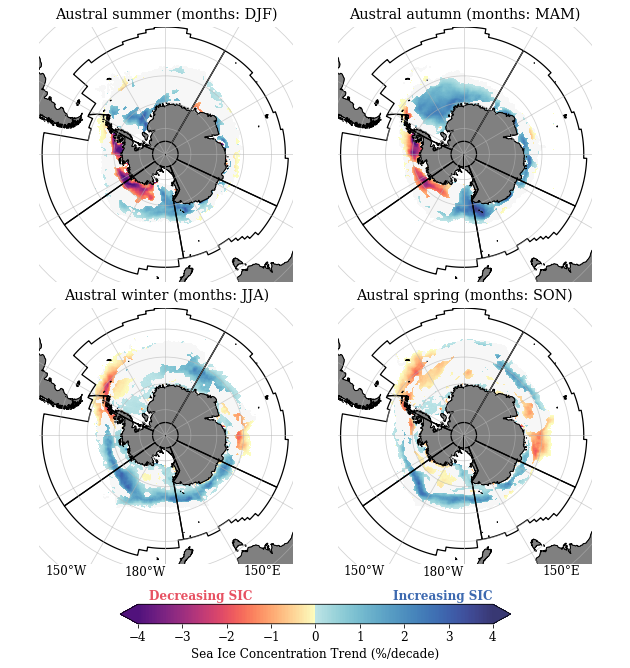

In [13]:
#Ensure folder where figures will be saved exists
folder_out = os.path.join(varDict['lm_fig'], 'Observations')
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Colormap settings
#Create colormap for differences
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -4, vcenter = 0, vmax = 4)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#Set NA values to show as white
mymap.set_bad('white')
#######

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    
    #Extract information for each season and start plotting
    data = LM_results_obs[season].coefficients
    #Standard errors
    se = LM_results_obs[season].std_err
    
    #Create mask to cover non-significant trends (i.e., absolute trends less than std error
    #of trend)
    mask = xr.where(np.fabs(data) < se, 1, np.nan) 
    
    #Multiplying by 1000 to get percentages per decade
    p1 = (data*1000).where(data != 0).\
    plot.pcolormesh(ax = ax[season], cmap = mymap,
                    norm = divnorm, add_colorbar = False)
    #Apply mask
    mask.plot.contourf(colors = '#f7f7f7', ax = ax[season], 
                       add_colorbar = False)
    
    #Plot MEASO regions
    MEASO_fixed.plot(color = 'black', lw = 1.25, ax = ax[season])

    #Set title for each subplot.
    ax[season].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, extend = 'both',
                  label = 'Sea Ice Concentration Trend (%/decade)')

#Add labels to improve readability
#Get colormap to extract colors for labels
cb.ax.text(1.75, 1.25, 'Increasing SIC', color = mymap(0.85), fontweight = 'bold')
cb.ax.text(-3.75, 1.25, 'Decreasing SIC', color = mymap(0.25), fontweight = 'bold')

# fig.suptitle('Seasonal linear trends in sea ice concentration from observations (1979-2018)', 
#              y = 0.93)

fn = 'SeasonalLinearTrends_Obs_SeaIceConcentration_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

## Comparing linear trends from observations and model outputs
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.

In [14]:
#Empty dictionary that will hold reprojected observations data
LM_obs_reproj = {}
LM_mod = {}

for key in LM_results_obs:
    obs = LM_results_obs[key].coefficients
    LM_obs_reproj[key] = zsf.reproject_latlon_coords(obs, 'epsg:3976', 'epsg:4326')
    mod = seasons_SIC[key].sel(yt_ocean = slice(-90, -50))
    LM_mod[key] = mod.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

### Loading regridded model outputs from disk to avoid recalculation

In [15]:
filelist = glob(os.path.join(varDict['base_data'], 'Regridded/*2018.nc'))

reg_mod = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    reg_mod[season] = xr.open_dataarray(file[0])

## Calculating seasonal linear trends for regridded model data

In [40]:
#Folder where linear trends will be saved
dir_out = os.path.join(varDict['linear_trends'], 'Regridded')
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Empty dictionary to store results
LM_results_mod = {}

#Calculating linear trend for each season
for season in reg_mod:
    #Define file name
    fn = f'LinearTrend_SIC_reg-mod_{season}_1979-2018.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(reg_mod[season].time))
    #Extract values from SIC data and create a vector
    vals = reg_mod[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(reg_mod[season][0].shape), 
                          dims = ["y", "x"],
                          coords = dict(x = reg_mod[season].xgrid.values, 
                                        y = reg_mod[season].ygrid.values),
                          name = "coefficients")   

    pval_r = xr.DataArray(data = p.reshape(reg_mod[season][0].shape), 
                          dims = ["y", "x"],
                          coords = dict(x = reg_mod[season].xgrid.values, 
                                        y = reg_mod[season].ygrid.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(reg_mod[season][0].shape), 
                          dims = ["y", "x"],
                          coords = dict(x = reg_mod[season].xgrid.values, 
                                        y = reg_mod[season].ygrid.values),
                          name = "std_err")

    LM_results_mod[season] = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results_mod[season].to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends calculated from regridded model outputs from disk to avoid recalculation

In [17]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Regridded/*2018.nc'))

LM_results_mod = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results_mod[season] = xr.open_dataset(file[0])

## Calculating differences in seasonal trends

In [44]:
folder_out = os.path.join(varDict['linear_trends'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)

#Empty dictionary that will hold reprojected observations data
LM_dif_obs_mod = {}
LM_dirdif_obs_mod = {}

for key in LM_results_mod:
    #Load coefficients
    coefs_obs = LM_results_obs[key].coefficients
    coefs_mod = LM_results_mod[key].coefficients
    #Calculating differences
    LM_dif_obs_mod[key] = coefs_obs - coefs_mod
    #Saving differences (obs - mod)
    fn_magdif = f'DifMag_LinearTrend_SIC_obs-mod_{key}_1979-2018.nc'
    LM_dif_obs_mod[key].to_netcdf(os.path.join(folder_out, fn_magdif))
    
    #Calculating differences in direction
    #Observations
    obs_dir = xr.where(coefs_obs > 0, 1, -1)
    obs_dir = xr.where(coefs_obs == 0, 0, obs_dir)
    obs_dir = xr.where(np.isnan(coefs_obs), np.nan, obs_dir)
    #Model outputs
    mod_dir = xr.where(coefs_mod > 0, 1, -1)
    mod_dir = xr.where(coefs_mod == 0, 0, mod_dir)
    mod_dir = xr.where(np.isnan(coefs_mod), 
                       np.nan, mod_dir)
    #Difference in direction
    LM_dirdif_obs_mod[key] = obs_dir-mod_dir
    #Saving results
    fn_dirdif = f'DifDir_LinearTrend_SIC_obs-mod_{key}_1979-2018.nc'
    LM_dirdif_obs_mod[key].to_netcdf(os.path.join(folder_out, fn_dirdif))

### Loading differences from disk to avoid recalculation

In [20]:
#Getting files of magnitude and direction differences
filesDirDif = sorted(glob(os.path.join(varDict['linear_trends'], 'Regridded/DifDir*2018.nc')))
filesMagDif = sorted(glob(os.path.join(varDict['linear_trends'], 'Regridded/DifMag*2018.nc')))

#Empty dictionary that will hold reprojected observations data
LM_dif_obs_mod = {}
LM_dirdif_obs_mod = {}

for season in seasonName:
    fileDir = [fd for fd in filesDirDif if season in fd]
    fileMag = [fm for fm in filesMagDif if season in fm]
    LM_dif_obs_mod[season] = xr.open_dataarray(fileMag[0])
    LM_dirdif_obs_mod[season] = xr.open_dataarray(fileDir[0])

In [45]:
for sea in LM_dif_obs_mod:
    print(LM_dif_obs_mod[sea].min().values*1000,
          LM_dif_obs_mod[sea].max().values*1000)

-7.694143868224229 4.3674597845487355
-4.542091947835859 3.1086892486565496
-3.1349448861657883 2.7496523738473475
-3.4489633394008763 2.8179948406837423


## Plotting differences in trend magnitude between observations and model outputs

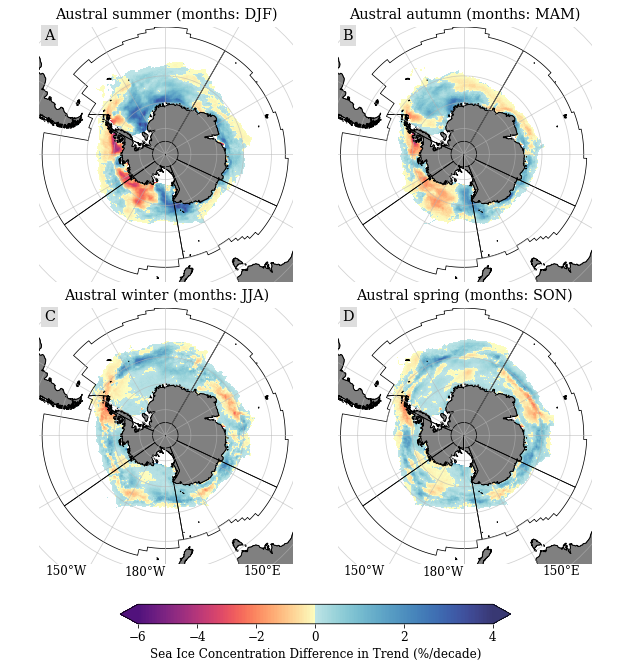

In [47]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Colormap settings
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -6, vcenter = 0, vmax = 4)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
mymap.set_bad('white')

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_dif_obs_mod[season]*1000
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = mymap, norm = divnorm,
                              add_colorbar = False)
    xr.where(data > 5, True, 0).plot.contour(colors = 'red', add_colorbar = False,
                          linewidths = 0.1, ax = ax[season])
    xr.where(data > 10, True, 0).plot.contour(colors = 'red', add_colorbar = False,
                          linewidths = 0.15, ax = ax[season], linestyle = '-')
    
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])
    #Plot any areas with zero trends as white
    xr.where(data == 0, 1, np.nan).plot.contourf(ax = ax[season], cmap = 'white',
                                                 add_colorbar = False)

    #Set title for each subplot.
    ax[season].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, extend = 'both',
                  label = 'Sea Ice Concentration Difference in Trend (%/decade)')

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:4]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.02, .95, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

# fig.suptitle('Differences in sea ice concentration linear trends between \n observations and model outputs (1979-2008)', 
#              y = 0.95)

fn = 'Diffs_Obs-Mod_SeasonalTrends_SeaIceConcentration_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

### Plotting differences in trend direction between observations and model outputs

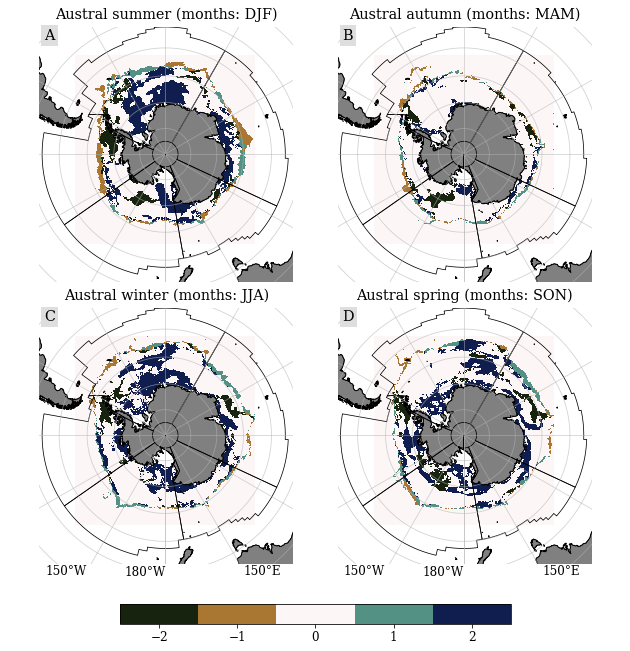

In [49]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_dirdif_obs_mod[season]
    #Creating a colorbar from 'tarn' that contains five levels
    cmap = plt.get_cmap(cm.cm.tarn, 5)
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = cmap, 
                              #Levels and limits are 0.5 units wider than 
                              #actual measurements
                              levels = np.arange(-2.5, 2.6, 1),
                              vmin = -2.5, vmax = 2.5,
                              add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])

    #Set title for each subplot.
    ax[season].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  #Ticks in colorbar match the data range
                  ticks = np.arange(-2, 2.1),
                  label = '')

# fig.suptitle('Differences in sea ice concentration linear trend direction between \n observations and model outputs (1979-2008)', 
#              y = 0.95)

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:4]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.02, .95, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

fn = 'DirDiffs_Obs-Mod_SeasonalTrends_SeaIceConcentration_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

# Calculating SIC summary statistics

In [57]:
#Calculating seasonal means and standard deviation for SIC
#Selecting only pixels with sea ice and transforming to percentages
SIC_clim = climdata.where(climdata > 0)*100

#Printing mean and standard deviation for each season
for season, da in SIC_clim.groupby('time.season'):
    print(season, round(da.mean().values.tolist(), 1),
          round(da.std().values.tolist(), 1))

DJF 51.3 25.2
JJA 85.5 37.2
MAM 75.9 35.2
SON 81.6 36.7


In [59]:
#Printing quantiles for each season
for season, da in SIC_clim.groupby('time.season'):
    print(season, da.quantile([0.25, 0.5, 0.75]).round(2).values)

DJF [27.16 51.63 75.12]
JJA [87.2  94.03 97.1 ]
MAM [56.05 91.95 97.87]
SON [81.37 89.64 93.59]


## Loading MEASO regions

In [12]:
#Defining sector names in order
sectorNames = ['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific']

In [13]:
#Loading mask
regions = xr.load_dataarray('MEASO_SIS_3Dmask.nc')

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    MEASOregions[i] = regions.sel(region = i)
    
MEASOregions.keys()

dict_keys(['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific'])

In [62]:
#Ensuring output folder exists
out_file = varDict['clipped_data']
os.makedirs(out_file, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIC = {}

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    for season, da in SIC_clim.groupby('time.season'):
        clip = da*MEASOregions[sector]
        print(sector, season, round(clip.mean().values.tolist(), 1), 
              round(clip.std().values.tolist(), 1))

Atlantic DJF 56.0 27.1
Atlantic JJA 89.8 17.8
Atlantic MAM 78.8 27.5
Atlantic SON 84.6 18.1
Central Indian DJF 40.6 21.2
Central Indian JJA 80.3 23.4
Central Indian MAM 63.7 29.5
Central Indian SON 79.0 22.4
East Indian DJF 39.6 22.9
East Indian JJA 77.3 24.4
East Indian MAM 66.5 29.2
East Indian SON 71.6 24.6
West Pacific DJF 52.7 24.8
West Pacific JJA 87.9 18.7
West Pacific MAM 80.7 25.6
West Pacific SON 84.6 18.4
East Pacific DJF 47.1 25.3
East Pacific JJA 81.0 24.4
East Pacific MAM 70.7 29.7
East Pacific SON 77.6 24.9


In [63]:
#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    for season, da in SIC_clim.groupby('time.season'):
        clip = da*MEASOregions[sector]
        print(sector, season, 
              clip.quantile([0.25, 0.5, 0.75]).round(2).values)

Atlantic DJF [30.81 59.45 80.97]
Atlantic JJA [92.41 95.33 98.32]
Atlantic MAM [61.63 95.35 98.75]
Atlantic SON [84.89 90.36 93.66]
Central Indian DJF [21.57 38.51 56.67]
Central Indian JJA [75.47 90.64 95.31]
Central Indian MAM [36.29 70.63 92.13]
Central Indian SON [75.14 88.1  93.14]
East Indian DJF [19.38 34.63 56.92]
East Indian JJA [68.73 88.86 93.5 ]
East Indian MAM [39.82 78.04 92.55]
East Indian SON [58.24 82.22 89.47]
West Pacific DJF [29.97 55.2  76.08]
West Pacific JJA [90.54 94.46 96.8 ]
West Pacific MAM [69.82 94.62 98.05]
West Pacific SON [85.65 90.7  93.95]
East Pacific DJF [23.53 44.9  69.98]
East Pacific JJA [74.02 93.12 97.08]
East Pacific MAM [45.01 84.33 96.86]
East Pacific SON [68.2  89.43 94.62]


# Calculating Sea Ice Extent (SIE) and Marginal Ice Zone (MIZ)
Sea ice extent is calculated based on Hobbs et al 2016, which is the total area covered where sea ice concentration is 15% or more. MIZ is defined as the area where SIC is between 15% and 80%.

In [7]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg_all_areas.nc')

## SIE and MIZ from model outputs

In [69]:
#Ensure output folder exists
folder_out = varDict['base_data']
os.makedirs(folder_out, exist_ok = True)

#Only keep area pixels where sea ice concentration is 15% or more
SIE = xr.where(SIC >= 0.15, IceArea, np.nan)
MIZ = xr.where(((SIC >= 0.15) & (SIC <= 0.8)), IceArea, np.nan)

#Save sea ice extent
fn = f'SeaIceExtent_{SIE.time.dt.year.values.min()}-{SIE.time.dt.year.values.max()}.nc'
SIE.to_netcdf(os.path.join(folder_out, fn))

fn_m = f'MIZ_{MIZ.time.dt.year.values.min()}-{MIZ.time.dt.year.values.max()}.nc'
MIZ.to_netcdf(os.path.join(folder_out, fn_m))

### Loading sea ice extent to avoid recalculation

In [8]:
SIE = xr.open_dataarray(glob(os.path.join(varDict['base_data'], '*Ext*.nc'))[0])
SIE = SIE.sel(time = slice('1978-12', '2018-11'))

MIZ = xr.open_dataarray(glob(os.path.join(varDict['base_data'], '*MIZ*.nc'))[0])
MIZ = MIZ.sel(time = slice('1978-12', '2018-11'))

## SIE from daily model outputs

In [7]:
#Output folder where daily calculations will be saved
dir_out = os.path.join(varDict['base_data'], 'daily')
os.makedirs(dir_out, exist_ok = True)

#Applying calculations to tim period of interest
for yr in range(1978, 2019):
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata('aice', f'{str(yr)}-01',
                           f'{str(yr+1)}-01', freq = '1 daily', 
                           ses = session, minlat = -80, maxlat = -50,
                           ice_data = True).sel(time = slice(f'{str(yr)}-01', 
                                                             f'{str(yr)}-12'))
    #Extracting mask for pixels where sea ice has a concentration over 0.15
    SO = xr.where(SO >= 0.15, 1, np.nan)
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Getting area for each pixel in mask
    SIE_daily = SO*IceArea
    #Creating name of file
    fn = f'DailySeaIceExtent_{str(yr)}.nc'
    #Saving file
    SIE_daily.to_netcdf(os.path.join(dir_out, fn))

### Calculating total SIE per sector per day from masked data

In [9]:
#Get list of files in disk
filelist = sorted(glob(os.path.join(varDict['base_data'], 'daily/*Extent*.nc')))

#Output folder to save outputs
dir_out = os.path.join(varDict['base_data'], 'daily')
os.makedirs(dir_out, exist_ok = True)

#Calculate daily SIE values
for file in filelist:
    #Load file containing day for one year
    da = xr.open_dataarray(file)
    #Applying sector mask
    for sector in sectorNames:
        #Calculate total SIE per sector for each day
        sie_t = (MEASOregions[sector]*da).sum(('xt_ocean', 'yt_ocean'))
        #Saving outputs to disk
        yr = sie_t.time.dt.year.values[0]
        fn = f'Daily_SIE_{sector}_{yr}.nc'
        sie_t.to_netcdf(os.path.join(dir_out, fn))

### Loading data daily SIE data from disk

In [21]:
#Location of files
filelist = sorted(glob(os.path.join(varDict['base_data'], 'daily/*SIE*.nc')))

#Loading files to a dictionary
SIE_daily = {}
for sector in sectorNames:
    #Selecting all files for each sector
    sec_list = [f for f in filelist if sector in f]
    #Opening all files into dataset
    SIE_daily[sector] = xr.open_mfdataset(sec_list).\
    __xarray_dataarray_variable__.rename('SIE')

In [90]:
file_out = os.path.join(varDict['base_data'], 'SIE_daily')
os.makedirs(file_out, exist_ok = True)

for sec in SIE_daily:
    fn = f'Daily_SIE_{sec}_1978-2018.csv'
    SIE_daily[sec].to_series().to_csv(os.path.join(file_out, fn))

In [66]:
#Years included in analysis
time_range = range(1979, 2019)
#Initialise empty dictionary to store results
seasonal_linear_trends = {}

#Loop through sectors and seasons
for sector in SIE_daily:
    da_sec = SIE_daily[sector].sel(time = slice('1978-12', '2018-11'))
    for season, da in da_sec.groupby('time.season'):
        time_ind = np.arange(0, len(da))
        vals = da.values
        slope, intercept, r, p, se = zsf.lm_yr(y = vals, x = time_ind)
        seasonal_linear_trends[f'{sector}_{season}'] = xr.Dataset(data_vars = dict(
            slope = ('season', [slope]), 
            intercept = ('season', [intercept]),
            r = ('season', [r]), p = ('season', [p]), 
            se = ('season', [se])), coords = dict(season = [season], 
                                                  sector = [sector]))

In [23]:
#Years included in analysis
time_range = range(1979, 2019)
#Initialise empty dictionary to store results
seasonal_daily_ts = {}

#Loop through sectors and seasons
for sector in SIE_daily:
    for season, da in SIE_daily[sector].groupby('time.season'):
        da_mean = []
        da_std = []
        for yr in time_range:
            if season != 'DJF':
                da_mean.append(da.sel(time = str(yr)).mean().values.tolist())
                da_std.append(da.sel(time = str(yr)).std().values.tolist())
            else:
                da_mean.append(da.sel(time = slice(f'{str(yr-1)}-12', 
                                                   f'{str(yr)}-02')).mean().\
                               values.tolist())
                da_std.append(da.sel(time = slice(f'{str(yr-1)}-12', 
                                                   f'{str(yr)}-02')).std().\
                              values.tolist())
        #Rearrange results into data arrays
        da_mean = xr.DataArray(data = da_mean, dims = ['time'], 
                               coords = {'time': time_range}, 
                               name = 'mean')
        da_std = xr.DataArray(data = da_std, dims = ['time'], 
                              coords = {'time': time_range}, 
                              name = 'std')
        #Merge results and store as dataset
        seasonal_daily_ts[f'{sector}_{season}'] = xr.merge([da_mean, da_std])

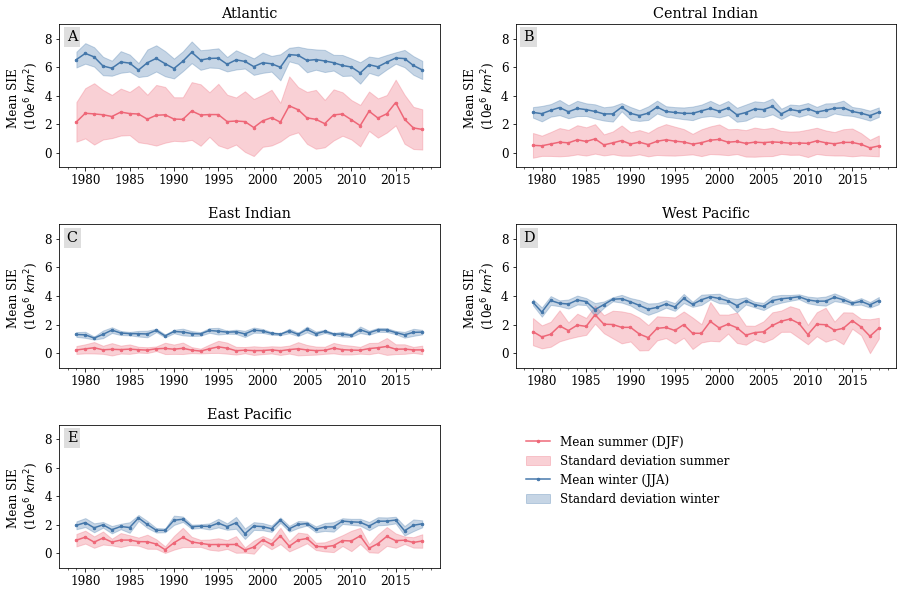

In [26]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

for i, sec in enumerate(sectorNames):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    data_summer = seasonal_daily_ts[f'{sec}_DJF']*1e-6
    data_winter = seasonal_daily_ts[f'{sec}_JJA']*1e-6
        
    #Plotting values
    #Summer
    data_summer['mean'].plot(ax = ax[sec], color = '#ee6677', marker = 'o', 
                             markersize = 2.5, label = 'Mean summer (DJF)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_summer['mean'].time.values, 
                         (data_summer['mean']+data_summer['std']).values,
                         (data_summer['mean']-data_summer['std']).values,
               alpha = 0.3, color = '#ee6677', label = 'Standard deviation summer')
    
    #Winter
    data_winter['mean'].plot(ax = ax[sec], color = '#4477aa', marker = 'o', 
                             markersize = 2.5, label = 'Mean winter (JJA)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_winter['mean'].time.values, 
                         (data_winter['mean']+data_winter['std']).values,
                         (data_winter['mean']-data_winter['std']).values,
               alpha = 0.3, color = '#4477aa', label = 'Standard deviation winter')
       
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Remove scientific notation from y axis and include it in label 
    exp_yaxis = int(np.floor(np.log10(int(data_winter['mean'].max().values))))
    plt.ylabel('Mean SIE \n' + r'(10$e^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    ax[sec].set_ylim([-1e6, 9e6])
    ax[sec].xaxis.set_minor_locator(AutoMinorLocator(n = 5))
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left', frameon = False)
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)
  
#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.02, .88, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'SeasonalMeansSector_DailyData_SeaIceExtent_1979-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

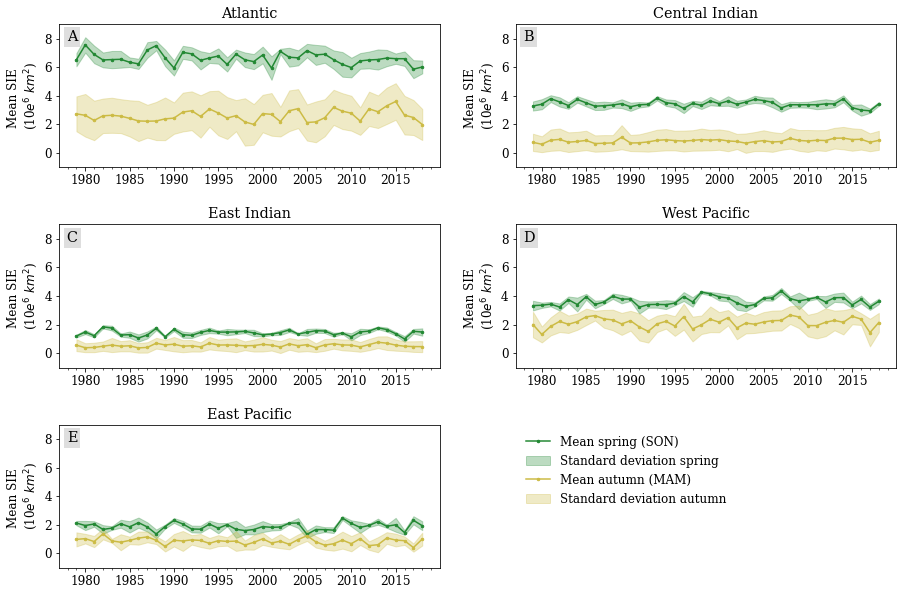

In [29]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

for i, sec in enumerate(sectorNames):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    data_spring = seasonal_daily_ts[f'{sec}_SON']*1e-6
    data_autumn = seasonal_daily_ts[f'{sec}_MAM']*1e-6
        
    #Plotting values
    #Summer
    data_spring['mean'].plot(ax = ax[sec], color = '#228833', marker = 'o', 
                             markersize = 2.5, label = 'Mean spring (SON)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_spring['mean'].time.values, 
                         (data_spring['mean']+data_spring['std']).values,
                         (data_spring['mean']-data_spring['std']).values,
               alpha = 0.3, color = '#228833', label = 'Standard deviation spring')
    
    #Winter
    data_autumn['mean'].plot(ax = ax[sec], color = '#ccbb44', marker = 'o', 
                             markersize = 2.5, label = 'Mean autumn (MAM)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_autumn['mean'].time.values, 
                         (data_autumn['mean']+data_autumn['std']).values,
                         (data_autumn['mean']-data_autumn['std']).values,
               alpha = 0.3, color = '#ccbb44', label = 'Standard deviation autumn')
       
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Remove scientific notation from y axis and include it in label 
    exp_yaxis = int(np.floor(np.log10(int(data_spring['mean'].max().values))))
    plt.ylabel('Mean SIE \n' + r'(10$e^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    ax[sec].set_ylim([-1e6, 9e6])
    ax[sec].xaxis.set_minor_locator(AutoMinorLocator(n = 5))
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left', frameon = False)
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)
  
#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.02, .88, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'SeasonalMeansSector_SON-MAM_DailyData_SeaIceExtent_1979-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## SIE and MIZ from observations

In [7]:
#Location of observation files
filelist = sorted(glob('/g/data/v45/la6889/Observations/*.nc'))

#Load them as data array
iceObs = []
for yr in range(1978, 2019):
    file = [f for f in filelist if str(yr) in f]
    data = xr.open_dataarray(file[0]).groupby('time.month').mean('time')
    time = pd.date_range(f'{yr}-{data.month.values.min()}', 
                         f'{yr}-{data.month.values.max()}', freq = 'MS')
    data = data.rename({'month': 'time'})
    data['time'] = time
    iceObs.append(data)
iceObs = xr.concat(iceObs, dim = 'time').sel(time = slice('1978-12', '2018-11'))

#Only keep area pixels where sea ice concentration is 15% or more for SIE
SIE_obs = xr.where(iceObs >= 0.15, (25000**2), np.nan)

#Keep area pixels where sea ice concentration is between 15% and 80% for MIZ
MIZ_obs = xr.where(((iceObs >= 0.15) & (iceObs <= 0.8)), (25000**2), np.nan)

## Splitting data into MEASO regions

### Model outputs

In [72]:
#Ensuring output folder exists
out_folder = varDict['clipped_data']
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIE = {}
clipped_MIZ = {}

#Range of years included in data
minY = SIE.time.dt.year.values.min()
maxY = SIE.time.dt.year.values.max()

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    clip = []
    clip_m = []
    for t in SIE.time.values:
        #SIE
        sie_t = SIE.sel(time = t)
        sie_t = (sie_t*MEASOregions[sector]).sum(('xt_ocean', 'yt_ocean'))
        clip.append(sie_t)
        #MIZ
        miz_t = MIZ.sel(time = t)
        miz_t = (miz_t*MEASOregions[sector]).sum(('xt_ocean', 'yt_ocean'))
        clip_m.append(miz_t)
    clipped_SIE[sector] = xr.concat(clip, dim = 'time')
    clipped_MIZ[sector] = xr.concat(clip_m, dim = 'time')
    #Create name for output file
    #SIE
    fn = f'SeaIceExtent_{sector}_{minY}-{maxY}.nc'
    clipped_SIE[sector].to_netcdf(os.path.join(out_folder, fn))
    #MIZ
    fn_m = f'MIZ_{sector}_{minY}-{maxY}.nc'
    clipped_MIZ[sector].to_netcdf(os.path.join(out_folder, fn_m))

#### Loading clipped data to avoid recalculation

In [14]:
filelist = glob(os.path.join(varDict['clipped_data'], '*Extent*1978*.nc'))
filelist_m = glob(os.path.join(varDict['clipped_data'], '*MIZ*1978*.nc'))

#Create empty list to save clipped data 
clipped_SIE = {}
clipped_MIZ = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    clipped_SIE[sector] = xr.open_dataarray(fn[0])
    fn_m = [f_m for f_m in filelist_m if sector in f_m]
    clipped_MIZ[sector] = xr.open_dataarray(fn_m[0])

### Observations

In [ ]:
#Assigning CRS to MEASO regions
MEASO_fixed = MEASO_fixed.set_crs(epsg = 3976)

#Assigning CRS to observational data
SIE_obs.rio.set_spatial_dims(x_dim = 'xgrid', y_dim = 'ygrid', inplace = True)
SIE_obs.rio.write_crs(MEASO_fixed.crs, inplace = True)

MIZ_obs.rio.set_spatial_dims(x_dim = 'xgrid', y_dim = 'ygrid', inplace = True)
MIZ_obs.rio.write_crs(MEASO_fixed.crs, inplace = True)

In [36]:
#Ensuring output folder exists
out_folder = os.path.join(varDict['clipped_data'], 'Observations')
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Range of years included in data
minY = SIE_obs.time.dt.year.values.min()
maxY = SIE_obs.time.dt.year.values.max()

#Empty list to store clipped data 
clipped_SIE_obs = {}
clipped_MIZ_obs = {}

#Clipping data using MEASO sectors
for sec in np.unique(MEASO.sector):
    shp = MEASO.query(f'sector == "{sec}"')
    #SIE
    clipped_SIE_obs[sec] = SIE_obs.rio.clip(shp.geometry, invert = False)
    clipped_SIE_obs[sec] = clipped_SIE_obs[sec].sum(('xgrid', 'ygrid'))
    fn = f'SeaIceExtent_Obs_{sec}_{minY}-{maxY}.nc'
    clipped_SIE_obs[sec].to_netcdf(os.path.join(out_folder, fn))
    #MIZ
    clipped_MIZ_obs[sec] = MIZ_obs.rio.clip(shp.geometry, invert = False)
    clipped_MIZ_obs[sec] = clipped_MIZ_obs[sec].sum(('xgrid', 'ygrid'))
    fn_m = f'MIZ_Obs_{sec}_{minY}-{maxY}.nc'
    clipped_MIZ_obs[sec].to_netcdf(os.path.join(out_folder, fn_m))

#### Loading clipped observational data to avoid recalculation

In [202]:
filelist = glob(os.path.join(varDict['clipped_data'], 'Observations/*Extent*2018.nc'))
filelist_m = glob(os.path.join(varDict['clipped_data'], 'Observations/*MIZ*2018.nc'))

#Create empty list to save clipped data 
clipped_SIE_obs = {}
clipped_MIZ_obs = {}

for sector in sectorNames:
    #SIE
    fn = [f for f in filelist if sector in f]
    clipped_SIE_obs[sector] = xr.open_dataarray(fn[0])
    #MIZ
    fn_m = [f for f in filelist_m if sector in f]
    clipped_MIZ_obs[sector] = xr.open_dataarray(fn_m[0])

## Calculating monthly means for sea ice extent

### Model outputs

In [11]:
# Empty dictionaries to hold results
#SIE
month_mean_mod = {}
month_std_mod = {}
#MIZ
month_mean_miz_mod = {}
month_std_miz_mod = {}

for sector in clipped_SIE:
    #SIE
    month_mean_mod[sector] = clipped_SIE[sector].groupby('time.month').mean()
    month_std_mod[sector] = clipped_SIE[sector].groupby('time.month').std()
    #MIZ
    month_mean_miz_mod[sector] = clipped_MIZ[sector].groupby('time.month').mean()
    month_std_miz_mod[sector] = clipped_MIZ[sector].groupby('time.month').std()

### Observations

In [12]:
# Empty dictionaries to hold results
#SIE
month_mean_obs = {}
month_std_obs = {}
#MIZ
month_mean_miz_obs = {}
month_std_miz_obs = {}

for sector in clipped_SIE_obs:
    #SIE
    month_mean_obs[sector] = clipped_SIE_obs[sector].groupby('time.month').mean()
    month_std_obs[sector] = clipped_SIE_obs[sector].groupby('time.month').std()
    #MIZ
    month_mean_miz_obs[sector] = clipped_MIZ_obs[sector].groupby('time.month').mean()
    month_std_miz_obs[sector] = clipped_MIZ_obs[sector].groupby('time.month').std()

### Plotting comparison of  monthly sea ice extent means in model and observations

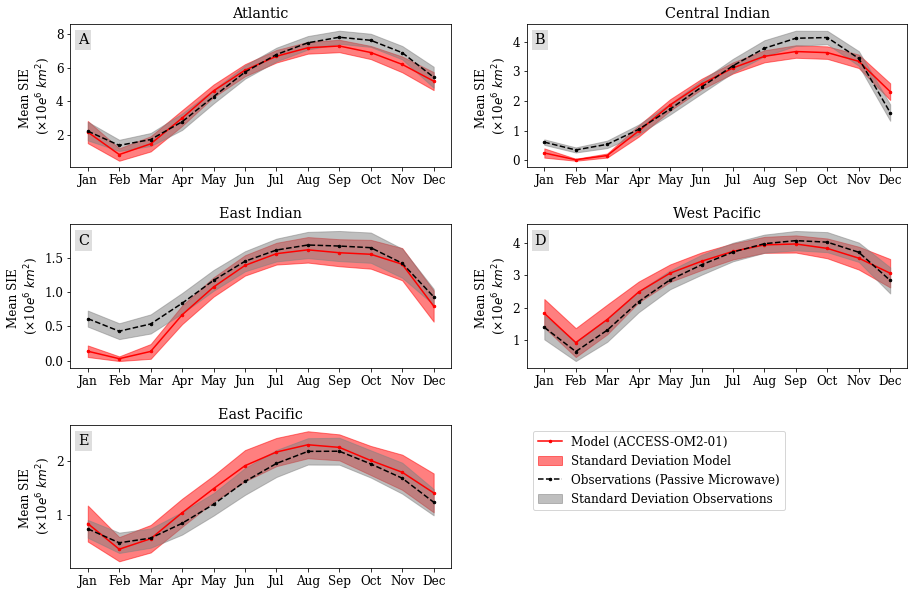

In [243]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Define max and min values for y axis
maxval = []
minval = []
for sec in month_mean_mod:
    maxval.append((month_mean_mod[sec].max()+month_std_mod[sec].max()).values)
    minval.append((month_mean_mod[sec].min()-month_std_mod[sec].max()).values)
    maxval.append((month_mean_obs[sec].max()+month_std_obs[sec].max()).values)
    minval.append((month_mean_obs[sec].min()-month_std_obs[sec].max()).values)
#Calculating max and min values to the nearest ten
maxval, minval = [(np.ceil(max(maxval)) + (1e12 - np.ceil(max(maxval))%1e12)), 
                  (np.floor(min(minval)) + (-1e12 - np.floor(min(minval))%1e12))]

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(month_mean_mod):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    #Model data
    data = month_mean_mod[sec]
    data['month'] = np.arange(1, 13)
    #Observational data
    obs = month_mean_obs[sec]
    obs['month'] = np.arange(1, 13)
    
    #Extract information for each season and start plotting
    #Values multiplied by 1e-6 to transform from m2 to km2
    #Model data
    coef = (data*1e-6)
    se = (month_std_mod[sec]*1e-6)
    
    #Observational data
    coef_obs = (obs*1e-6)
    se_obs = (month_std_obs[sec]*1e-6)
    
    #Plotting values
    #Model data
    #Add trends as lines and highlight significance with markers
    coef.plot(ax = ax[sec], color = 'red', marker = 'o', markersize = 2.5, 
              label = 'Model (ACCESS-OM2-01)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef.month, (coef+se).values, (coef-se).values,
               alpha = 0.5, color = 'red', label = 'Standard Deviation Model')
    
    #Observational data
    coef_obs.plot(ax = ax[sec], color = 'black', ls = '--', marker = 'o', markersize = 2.5,
                 label = 'Observations (Passive Microwave)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef_obs.month, (coef_obs+se_obs).values, (coef_obs-se_obs).values,
               alpha = 0.5, color = 'gray', label = 'Standard Deviation Observations')
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Label x ticks as months
    ax[sec].set_xticklabels(calendar.month_abbr[1:])
    #Get remove scientific notation from y axis and include it in label 
    exp_yaxis = np.floor(np.log10(int(coef.max().values)))
    plt.ylabel('Mean SIE \n' + r'($\times$10$e^{}$ $km^2$)'.format(int(exp_yaxis)))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)
    
#Adding title to overall figure
# fig.suptitle('Monthly mean in sea ice extent (1979-2018)', 
#              y = 0.95)

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.02, .86, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'MonthlyMeansSector_SeaIceExtent_1979-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, 
            bbox_inches = 'tight', 
            pad_inches = 0.05)

### Plotting comparison of monthly marginal zone extent in model and observations

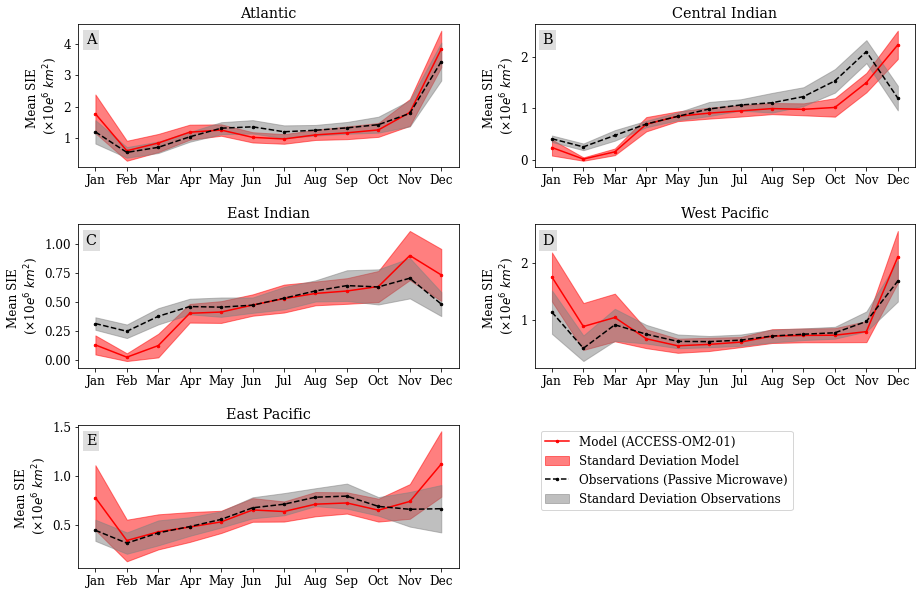

In [17]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(month_mean_miz_mod):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    #Model data
    data = month_mean_miz_mod[sec]
    data['month'] = np.arange(1, 13)
    #Observational data
    obs = month_mean_miz_obs[sec]
    obs['month'] = np.arange(1, 13)
    
    #Extract information for each season and start plotting
    #Values multiplied by 1e-6 to transform from m2 to km2
    #Model data
    coef = (data*1e-6)
    se = (month_std_miz_mod[sec]*1e-6)
    
    #Observational data
    coef_obs = (obs*1e-6)
    se_obs = (month_std_miz_obs[sec]*1e-6)
    
    #Plotting values
    #Model data
    #Add trends as lines and highlight significance with markers
    coef.plot(ax = ax[sec], color = 'red', marker = 'o', markersize = 2.5, 
              label = 'Model (ACCESS-OM2-01)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef.month, (coef+se).values, (coef-se).values,
               alpha = 0.5, color = 'red', label = 'Standard Deviation Model')
    
    #Observational data
    coef_obs.plot(ax = ax[sec], color = 'black', ls = '--', marker = 'o', markersize = 2.5,
                 label = 'Observations (Passive Microwave)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef_obs.month, (coef_obs+se_obs).values, (coef_obs-se_obs).values,
               alpha = 0.5, color = 'gray', label = 'Standard Deviation Observations')
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Label x ticks as months
    ax[sec].set_xticklabels(calendar.month_abbr[1:])
    #Get remove scientific notation from y axis and include it in label 
    exp_yaxis = np.floor(np.log10(int(coef.max().values+se.max().values)))
    plt.ylabel('Mean SIE \n' + r'($\times$10$e^{}$ $km^2$)'.format(int(exp_yaxis)))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)
    
#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.02, .86, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'MonthlyMeansSector_MIZ_1979-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Calculating seasonal timeseries
Calculations based on ACCESS-OM2-01 data only. Mean and standard deviation are calculated per year per season and per sector.

In [15]:
#Years included in analysis
time_range = range(1979, 2019)
#Initialise empty dictionary to store results
seasonal_ts = {}

#Loop through sectors and seasons
for sector in clipped_SIE:
    for season, da in clipped_SIE[sector].groupby('time.season'):
        da_mean = []
        da_std = []
        #Calculate mean and standard deviation per season per year
        for i in np.arange(1, len(da), 3):
            da_mean.append(da[i-1:i+2].mean().values.tolist())
            da_std.append(da[i-1:i+2].std().values.tolist())
        #Rearrange results into data arrays
        da_mean = xr.DataArray(data = da_mean, dims = ['time'], 
                               coords = {'time': time_range}, 
                               name = 'mean')
        da_std = xr.DataArray(data = da_std, dims = ['time'], 
                              coords = {'time': time_range}, 
                              name = 'std')
        #Merge results and store as dataset
        seasonal_ts[f'{sector}_{season}'] = xr.merge([da_mean, da_std])

### Calculating linear trends from yearly seasonal means

In [53]:
seasonal_linear_trends = {}

for sec_sea in seasonal_ts:
    da = seasonal_ts[sec_sea]['mean']
    sector = sec_sea.split('_')[0]
    season = sec_sea.split('_')[1]
    time_ind = np.arange(0, len(da))
    vals = da.values
    slope, intercept, r, p, se = zsf.lm_yr(y = vals, x = time_ind)
    seasonal_linear_trends[f'{sector}_{season}'] = xr.Dataset(data_vars = dict(
        slope = ('season', [slope]), 
        intercept = ('season', [intercept]),
        r = ('season', [r]), p = ('season', [p]), 
        se = ('season', [se])), coords = dict(season = [season], 
                                              sector = [sector]))

In [67]:
#Printing summary table of linear trends
da_seasonalLT = [seasonal_linear_trends[sec] for sec in seasonal_linear_trends]
ds = xr.combine_by_coords(da_seasonalLT)

reg_sea_pd = []
for sec in sectorNames:
    x = ds.sel(sector = sec).to_pandas()
    x['sector'] = sec
    reg_sea_pd.append(x)

reg_sea_pd = pd.concat(reg_sea_pd)
reg_sea_pd

,slope,intercept,r,p,se,sector
season,,,,,,
DJF,-6.650101e+09,2.880923e+12,-0.191875,0.235581,5.517876e+09,Atlantic
JJA,-6.606235e+09,6.696154e+12,-0.228480,0.156177,4.566384e+09,Atlantic
MAM,7.138162e+09,2.908153e+12,0.215233,0.182275,5.253950e+09,Atlantic
SON,-1.007512e+10,6.986725e+12,-0.303985,0.056519,5.122139e+09,Atlantic
DJF,-1.703602e+09,8.970299e+11,-0.156882,0.333669,1.739769e+09,Central Indian
JJA,1.399421e+08,3.065535e+12,0.009478,0.953714,2.395137e+09,Central Indian
MAM,4.290782e+09,9.250758e+11,0.381622,0.015107,1.685906e+09,Central Indian
SON,-3.819551e+09,3.624226e+12,-0.221055,0.170447,2.733637e+09,Central Indian
DJF,3.397679e+08,3.138133e+11,0.045447,0.780660,1.211548e+09,East Indian


In [68]:
#Checking significant p values
df = ds.to_dataframe()
df.p < 0.05

sector          season
Atlantic        DJF       False
                JJA       False
                MAM       False
                SON       False
Central Indian  DJF       False
                JJA       False
                MAM        True
                SON       False
East Indian     DJF       False
                JJA       False
                MAM       False
                SON       False
East Pacific    DJF       False
                JJA       False
                MAM       False
                SON       False
West Pacific    DJF       False
                JJA        True
                MAM       False
                SON       False
Name: p, dtype: bool

### Plotting seasonal timeseries

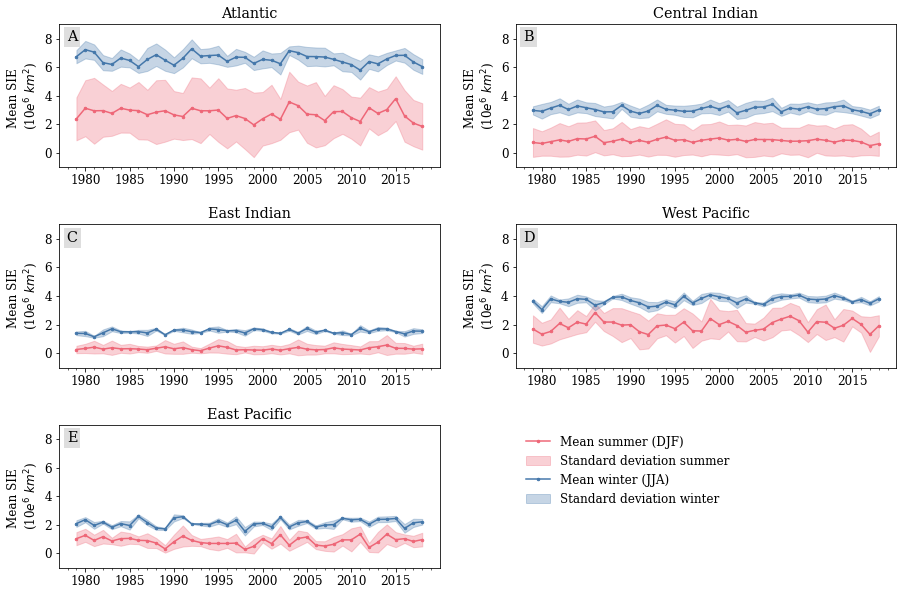

In [20]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

for i, sec in enumerate(sectorNames):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    data_summer = seasonal_ts[f'{sec}_DJF']*1e-6
    data_winter = seasonal_ts[f'{sec}_JJA']*1e-6
        
    #Plotting values
    #Summer
    data_summer['mean'].plot(ax = ax[sec], color = '#ee6677', marker = 'o', 
                             markersize = 2.5, label = 'Mean summer (DJF)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_summer['mean'].time.values, 
                         (data_summer['mean']+data_summer['std']).values,
                         (data_summer['mean']-data_summer['std']).values,
               alpha = 0.3, color = '#ee6677', label = 'Standard deviation summer')
    
    #Winter
    data_winter['mean'].plot(ax = ax[sec], color = '#4477aa', marker = 'o', 
                             markersize = 2.5, label = 'Mean winter (JJA)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_winter['mean'].time.values, 
                         (data_winter['mean']+data_winter['std']).values,
                         (data_winter['mean']-data_winter['std']).values,
               alpha = 0.3, color = '#4477aa', label = 'Standard deviation winter')
       
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Remove scientific notation from y axis and include it in label 
    exp_yaxis = int(np.floor(np.log10(int(data_winter['mean'].max().values))))
    plt.ylabel('Mean SIE \n' + r'(10$e^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    ax[sec].set_ylim([-1e6, 9e6])
    ax[sec].xaxis.set_minor_locator(AutoMinorLocator(n = 5))
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left', frameon = False)
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)
  
#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.02, .88, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'SeasonalMeansSector_SeaIceExtent_1979-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Calculating mean monthly linear trends for sea ice extent

### From model outputs

In [22]:
folder_out = os.path.join(varDict['linear_trends'], 'Monthly')
os.makedirs(folder_out, exist_ok = True)

LM_month_sec = {}

for sec in clipped_SIE:
    sub = clipped_SIE[sec].sel(time = slice('1979', '2018'))
    #Range of years included in data
    minY = sub.time.dt.year.values.min()
    maxY = sub.time.dt.year.values.max()
    coef_s = []
    se_s = []
    r_s = []
    p_s = []
    for month in range(1, 13):
        data = []
        for i, m in enumerate(sub.time.dt.month.values.tolist()):
            if m == month:
                data.append(sub[i])
        data = xr.concat(data, dim = 'time')
        time_ind = np.arange(0, len(data))
        #Extract values from SIC data and create a vector
        vals = data.values.tolist()
        #Save coefficients and pvalues for linear regression calculations
        slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)
        
        #Reshaping coefficients and pvalues to original dimensions of the data array
        coef_s.append(xr.DataArray(data = slope, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "coefficients"))
        se_s.append(xr.DataArray(data = se, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "std_err"))
        r_s.append(xr.DataArray(data = r, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "r_sq"))
        p_s.append(xr.DataArray(data = p, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "p_val"))
    #Concatening values before creating a data set
    coef_s = xr.concat(coef_s, dim = 'month')
    se_s = xr.concat(se_s, dim = 'month')
    r_s = xr.concat(r_s, dim = 'month')
    p_s = xr.concat(p_s, dim = 'month')
    
    #Creating data set
    LM_month_sec[sec] = xr.merge([coef_s, se_s, r_s, p_s])
    fn = f'MonthlyLinearTrend_SIE_{sec}.nc'
    LM_month_sec[sec].to_netcdf(os.path.join(folder_out, fn))

### From observations

In [23]:
folder_out = os.path.join(varDict['linear_trends'], 'Monthly/Observations')
os.makedirs(folder_out, exist_ok = True)

LM_month_sec_obs = {}

for sec in clipped_SIE_obs:
    sub = clipped_SIE_obs[sec].sel(time = slice('1979', '2018'))
    #Range of years included in data
    minY = sub.time.dt.year.values.min()
    maxY = sub.time.dt.year.values.max()
    coef_s = []
    se_s = []
    r_s = []
    p_s = []
    for month in range(1, 13):
        data = []
        for i, m in enumerate(sub.time.dt.month.values.tolist()):
            if m == month:
                data.append(sub[i])
        data = xr.concat(data, dim = 'time')
        time_ind = np.arange(0, len(data))
        #Extract values from SIC data and create a vector
        vals = data.values.tolist()
        #Save coefficients and pvalues for linear regression calculations
        slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)
        
        #Reshaping coefficients and pvalues to original dimensions of the data array
        coef_s.append(xr.DataArray(data = slope, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "coefficients"))
        se_s.append(xr.DataArray(data = se, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "std_err"))
        r_s.append(xr.DataArray(data = r, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "r_sq"))
        p_s.append(xr.DataArray(data = p, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "p_val"))
    #Concatening values before creating a data set
    coef_s = xr.concat(coef_s, dim = 'month')
    se_s = xr.concat(se_s, dim = 'month')
    r_s = xr.concat(r_s, dim = 'month')
    p_s = xr.concat(p_s, dim = 'month')
    
    #Creating data set
    LM_month_sec_obs[sec] = xr.merge([coef_s, se_s, r_s, p_s])
    fn = f'MonthlyLinearTrend_Obs_SIE_{sec}.nc'
    LM_month_sec_obs[sec].to_netcdf(os.path.join(folder_out, fn))

#### Loading clipped data to avoid recalculation

In [14]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Monthly/*SIE*.nc'))

#Create empty list to save clipped data 
LM_month_sec = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    LM_month_sec[sector] = xr.open_dataset(fn[0])

In [15]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Monthly/Observations/*SIE*.nc'))

#Create empty list to save clipped data 
LM_month_sec_obs = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    LM_month_sec_obs[sector] = xr.open_dataset(fn[0])

## Plotting comparison of  monthly sea ice extent trends in model and observations

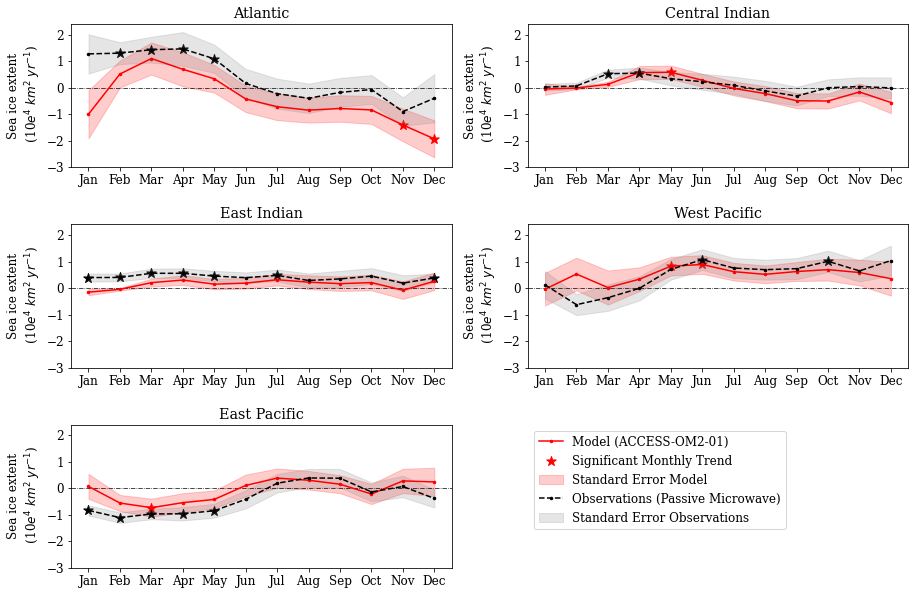

In [16]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Define max and min values for y axis
maxval = []
minval = []
for sec in LM_month_sec:
    data = LM_month_sec[sec]
    maxval.append((data.coefficients.max()+data.std_err.max()).values)
    minval.append((data.coefficients.min()-data.std_err.max()).values)
    data = LM_month_sec_obs[sec]
    maxval.append((data.coefficients.max()+data.std_err.max()).values)
    minval.append((data.coefficients.min()-data.std_err.max()).values)
#Calculating max and min values to the nearest ten
maxval, minval = [(np.ceil(max(maxval)) + (1e9 - np.ceil(max(maxval))%1e9)), 
                  (np.floor(min(minval)) + (-1e9 - np.floor(min(minval))%1e9))]

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(LM_month_sec):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    #Model data
    data = LM_month_sec[sec]
    data['month'] = np.arange(1, 13)
    #Observational data
    obs = LM_month_sec_obs[sec]
    obs['month'] = np.arange(1, 13)
    
    #Extract information for each season and start plotting
    #Values multiplied by 1e-6 to transform from m2 to km2
    #Model data
    coef = (data.coefficients*1e-6)
    se = (data.std_err*1e-6)
    sig = xr.where(data.p_val <= 0.05, coef, np.nan)
    
    #Observational data
    coef_obs = (obs.coefficients*1e-6)
    se_obs = (obs.std_err*1e-6)
    sig_obs = xr.where(obs.p_val <= 0.05, coef_obs, np.nan)
    
    #Plotting values
    #Model data
    #Adding horizontal line that makes it easier to distinguish positive and negative trends
    plt.axhline(y = 0, color = 'black', linestyle = '-.', lw = 0.7)
    #Add trends as lines and highlight significance with markers
    coef.plot(ax = ax[sec], color = 'red', marker = 'o', markersize = 2.5, 
              label = 'Model (ACCESS-OM2-01)')
    plt.scatter(coef.month.values, sig, marker = '*', s = 100, c = 'red', label = 'Significant Monthly Trend')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef.month, (coef+se).values, (coef-se).values,
               alpha = 0.2, color = 'red', label = 'Standard Error Model')
    
    #Observational data
    coef_obs.plot(ax = ax[sec], color = 'black', ls = '--', marker = 'o', markersize = 2.5,
                 label = 'Observations (Passive Microwave)')
    plt.scatter(coef_obs.month.values, sig_obs, marker = '*', s = 100, c = 'black')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef_obs.month, (coef_obs+se_obs).values, (coef_obs-se_obs).values,
               alpha = 0.2, color = 'gray', label = 'Standard Error Observations')
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Label x ticks as months
    ax[sec].set_xticklabels(calendar.month_abbr[1:])
    #Set y axis limits and increase number of ticks
    ax[sec].set_ylim(minval*1e-6, (maxval*1e-6))
    ax[sec].yaxis.set_major_locator(MultipleLocator(10000))
    #Change to scientific notation for y axis label
    ax[sec].ticklabel_format(style = 'scientific', axis = 'y', scilimits = (0, 0))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    exp_yaxis = int(np.floor(np.log10(maxval*1e-6)))
    #Set y axis label
    plt.ylabel(f'Sea ice extent\n (10$e^{exp_yaxis}$ ' + r'$km^{2}$ $yr^{-1}$)')
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)
    
#Saving figure
fn = 'MonthlyLinearTrends_SeaIceExtent_1979-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Calculating mean monthly linear trends for marginal ice zone

### From model outputs

In [94]:
folder_out = os.path.join(varDict['linear_trends'], 'Monthly')
os.makedirs(folder_out, exist_ok = True)

LM_miz_month_sec = {}

for sec in clipped_MIZ:
    sub = clipped_MIZ[sec].sel(time = slice('1979', '2018'))
    #Range of years included in data
    minY = sub.time.dt.year.values.min()
    maxY = sub.time.dt.year.values.max()
    coef_s = []
    se_s = []
    r_s = []
    p_s = []
    for month in range(1, 13):
        data = []
        for i, m in enumerate(sub.time.dt.month.values.tolist()):
            if m == month:
                data.append(sub[i])
        data = xr.concat(data, dim = 'time')
        time_ind = np.arange(0, len(data))
        #Extract values from SIC data and create a vector
        vals = data.values.tolist()
        #Save coefficients and pvalues for linear regression calculations
        slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)
        
        #Reshaping coefficients and pvalues to original dimensions of the data array
        coef_s.append(xr.DataArray(data = slope, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "coefficients"))
        se_s.append(xr.DataArray(data = se, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "std_err"))
        r_s.append(xr.DataArray(data = r, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "r_sq"))
        p_s.append(xr.DataArray(data = p, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "p_val"))
    #Concatening values before creating a data set
    coef_s = xr.concat(coef_s, dim = 'month')
    se_s = xr.concat(se_s, dim = 'month')
    r_s = xr.concat(r_s, dim = 'month')
    p_s = xr.concat(p_s, dim = 'month')
    
    #Creating data set
    LM_miz_month_sec[sec] = xr.merge([coef_s, se_s, r_s, p_s])
    fn = f'MonthlyLinearTrend_MIZ_{sec}.nc'
    LM_miz_month_sec[sec].to_netcdf(os.path.join(folder_out, fn))

#### Loading clipped data to avoid recalculation

In [17]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Monthly/*MIZ*.nc'))

#Create empty list to save clipped data 
LM_miz_month_sec = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    LM_miz_month_sec[sector] = xr.open_dataset(fn[0])

## Plotting monthly SIE and MIZ trends for model data

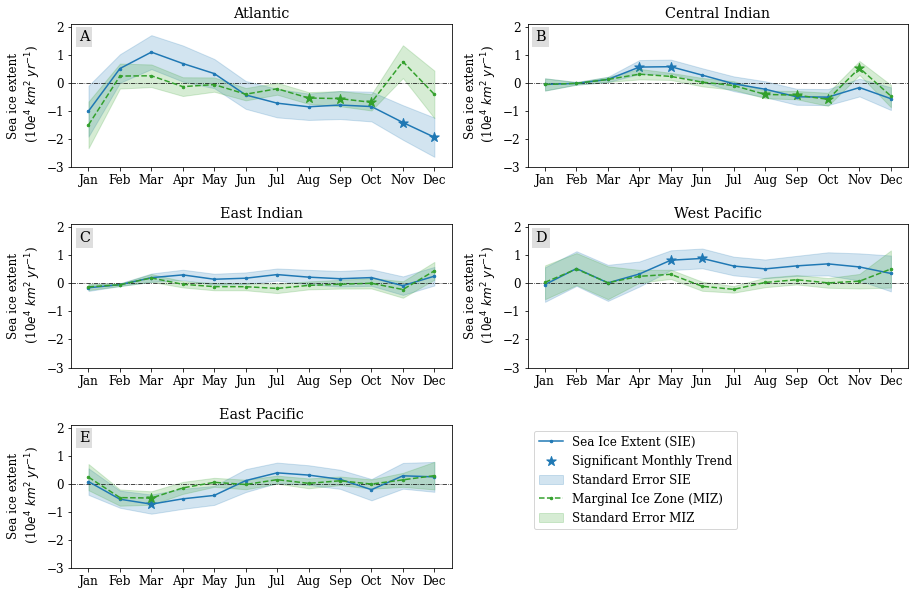

In [19]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Define max and min values for y axis
maxval = []
minval = []
for sec in LM_month_sec:
    data = LM_month_sec[sec]
    maxval.append((data.coefficients.max()+data.std_err.max()).values)
    minval.append((data.coefficients.min()-data.std_err.max()).values)
    data = LM_miz_month_sec[sec]
    maxval.append((data.coefficients.max()+data.std_err.max()).values)
    minval.append((data.coefficients.min()-data.std_err.max()).values)
#Calculating max and min values to the nearest ten
maxval, minval = [(np.ceil(max(maxval)) + (1e9 - np.ceil(max(maxval))%1e9)), 
                  (np.floor(min(minval)) + (-1e9 - np.floor(min(minval))%1e9))]

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(LM_month_sec):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    #Model data
    data = LM_month_sec[sec]
    data['month'] = np.arange(1, 13)
    #Observational data
    miz = LM_miz_month_sec[sec]
    miz['month'] = np.arange(1, 13)
    
    #Extract information for each season and start plotting
    #Values multiplied by 1e-6 to transform from m2 to km2
    #Model data
    coef = (data.coefficients*1e-6)
    se = (data.std_err*1e-6)
    sig = xr.where(data.p_val <= 0.05, coef, np.nan)
    
    #Observational data
    coef_miz = (miz.coefficients*1e-6)
    se_miz = (miz.std_err*1e-6)
    sig_miz = xr.where(miz.p_val <= 0.05, coef_miz, np.nan)
    
    #Plotting values
    #Model data
    #Adding horizontal line that makes it easier to distinguish positive and negative trends
    plt.axhline(y = 0, color = 'black', linestyle = '-.', lw = 0.7)
    #Add trends as lines and highlight significance with markers
    coef.plot(ax = ax[sec], color = '#1f78b4', marker = 'o', markersize = 2.5, 
              label = 'Sea Ice Extent (SIE)')
    plt.scatter(coef.month.values, sig, marker = '*', s = 100, c = '#1f78b4', label = 'Significant Monthly Trend')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef.month, (coef+se).values, (coef-se).values,
               alpha = 0.2, color = '#1f78b4', label = 'Standard Error SIE')
    
    #Observational data
    coef_miz.plot(ax = ax[sec], color = '#33a02c', ls = '--', marker = 'o', markersize = 2.5,
                 label = 'Marginal Ice Zone (MIZ)')
    plt.scatter(coef_miz.month.values, sig_miz, marker = '*', s = 100, c = '#33a02c')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef_miz.month, (coef_miz+se_miz).values, (coef_miz-se_miz).values,
               alpha = 0.2, color = '#33a02c', label = 'Standard Error MIZ')
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Label x ticks as months
    ax[sec].set_xticklabels(calendar.month_abbr[1:])
    #Set y axis limits and increase number of ticks
    ax[sec].set_ylim(minval*1e-6, (maxval*1e-6))
    ax[sec].yaxis.set_major_locator(MultipleLocator(10000))
    #Change to scientific notation for y axis label
    ax[sec].ticklabel_format(style = 'scientific', axis = 'y', scilimits = (0, 0))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    exp_yaxis = int(np.floor(np.log10(maxval*1e-6)))
    #Set y axis label
    plt.ylabel(f'Sea ice extent\n (10$e^{exp_yaxis}$ ' + r'$km^{2}$ $yr^{-1}$)')
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.02, .88, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'MonthlyLinearTrends_SIE-MIZ_1979-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Calculating IQR per season and region

In [242]:
#Create empty list to store calculations
sea_SIE = []
sea_MIZ = []

#Saving each sector as an entry in the dictionary
for sec in clipped_SIE:
    #Calculate quantiles calculated per season
    sea_SIE.append(clipped_SIE[sec].groupby('time.season').\
                   quantile([.25, .5, .75]).expand_dims({'region': [sec]}))
    sea_MIZ.append(clipped_MIZ[sec].groupby('time.season').\
                   quantile([.25, .5, .75]).expand_dims({'region': [sec]}))

#Create a data array from list
sea_SIE = xr.combine_by_coords(sea_SIE)
sea_MIZ = xr.combine_by_coords(sea_MIZ)

### Re-arranging IQR summaries in a data frame

In [244]:
reg_sea_SIEpd = []
reg_sea_MIZpd = []

seasonNames = {'Summer': 'DJF', 'Autumn': 'MAM', 
              'Winter': 'JJA', 'Spring': 'SON'}
for sea in seasonNames:
    #Values multiplied by 1e-6 to transform from m2 to km2
    x = (sea_SIE.sel(season = seasonNames[sea])*1e-6).to_pandas()
    x['season'] = sea
    reg_sea_SIEpd.append(x)
    y = (sea_MIZ.sel(season = seasonNames[sea])*1e-6).to_pandas()
    y['season'] = sea
    reg_sea_MIZpd.append(y)

reg_sea_SIEpd = pd.concat(reg_sea_SIEpd)
reg_sea_MIZpd = pd.concat(reg_sea_MIZpd)
reg_sea_SIEpd

quantile,0.25,0.5,0.75,season
region,,,,
Atlantic,1.034635e+06,2.111917e+06,4.882623e+06,Summer
Central Indian,2.358325e+04,2.277376e+05,2.131334e+06,Summer
East Indian,3.282893e+04,1.457181e+05,6.180520e+05,Summer
East Pacific,4.444018e+05,7.797129e+05,1.266234e+06,Summer
West Pacific,1.123237e+06,1.851512e+06,2.762690e+06,Summer
Atlantic,1.787096e+06,2.951981e+06,4.419868e+06,Autumn
Central Indian,2.187052e+05,9.777661e+05,1.696719e+06,Autumn
East Indian,1.675878e+05,6.800431e+05,9.379166e+05,Autumn
East Pacific,6.902298e+05,1.052548e+06,1.391052e+06,Autumn


In [245]:
reg_sea_MIZpd

quantile,0.25,0.5,0.75,season
region,,,,
Atlantic,7.166460e+05,1.806124e+06,3.462883e+06,Summer
Central Indian,2.199946e+04,2.174369e+05,2.014421e+06,Summer
East Indian,3.277525e+04,1.416267e+05,5.738847e+05,Summer
East Pacific,4.237599e+05,7.191975e+05,1.065335e+06,Summer
West Pacific,1.077424e+06,1.653497e+06,2.023841e+06,Summer
Atlantic,9.292309e+05,1.134550e+06,1.316620e+06,Autumn
Central Indian,2.129599e+05,6.813931e+05,8.263630e+05,Autumn
East Indian,1.590686e+05,3.664663e+05,4.175362e+05,Autumn
East Pacific,3.713568e+05,4.811702e+05,5.688974e+05,Autumn


## Identifying extreme SIE values

In [ ]:
#Calculate climatological means and 90th percentile per sector and season
clim = {}
per90 = {}
per10 = {}

for key in clipped_SIE:
    clim[key] = clipped_SIE[key].sel(time = slice('1979', '2018')).groupby('time.month').mean()
    p90 = clipped_SIE[key].quantile(.9).values.tolist()
    per90[key] = xr.DataArray(data = [p90]*(len(clipped_SIE[key].time)),
                 dims = 'time', 
                 coords = {'time': clipped_SIE[key].time.values})
    p10 = clipped_SIE[key].quantile(.1).values.tolist()
    per10[key] = xr.DataArray(data = [p10]*(len(clipped_SIE[key].time)),
                 dims = 'time', 
                 coords = {'time': clipped_SIE[key].time.values})

In [ ]:
folder_out = varDict['mean_sector_time_series']
os.makedirs(folder_out, exist_ok = True)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.3, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(clipped_SIE):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Plotting values
    (per10[sec]*1e-6).plot(ax = ax[sec], color = '#998ec3', label = '10th percentile')
    (per90[sec]*1e-6).plot(ax = ax[sec], color = '#f1a340', label = '90th percentile')
    (clipped_SIE[sec]*1e-6).plot(ax = ax[sec], color = '#7b7b7b', lw = 1, marker = '.',
                                markersize = 4)
    ax[sec].fill_between(per90[sec].time, per90[sec]*1e-6,
                xr.where((clipped_SIE[sec]*1e-6) > per90[sec]*1e-6, 
                         (clipped_SIE[sec]*1e-6), np.nan),
                color = '#f1a340')
    xr.where((clipped_SIE[sec]*1e-6) > per90[sec]*1e-6, 
                             (clipped_SIE[sec]*1e-6), per90[sec]*1e-6).plot(ax = ax[sec], 
                                                                            color = '#f1a340', 
                                                                            lw = 1, marker = '.',
                                                                            markersize = 4)
    ax[sec].fill_between(per10[sec].time, 
                    xr.where((clipped_SIE[sec]*1e-6) < per10[sec]*1e-6, 
                             (clipped_SIE[sec]*1e-6), np.nan),
                    per10[sec]*1e-6, color = '#998ec3', edgecolor = '#998ec3')
    xr.where((clipped_SIE[sec]*1e-6) < per10[sec]*1e-6, 
                             (clipped_SIE[sec]*1e-6), per10[sec]*1e-6).plot(ax = ax[sec], 
                                                                            color = '#998ec3', 
                                                                            lw = 1, marker = '.',
                                                                            markersize = 4)
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    ax[sec].set_ylabel('Sea ice extent ($km^{2}$/year)')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Get remove scientific notation from y axis and include it in label 
    exp_yaxis = np.floor(np.log10(max(ax[sec].get_yticks()))).astype(int)
    plt.ylabel('Mean monthly SIE \n' + r'($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    ax[sec].xaxis.set_minor_locator(AutoMinorLocator(n = 12))
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)

#Adding title to overall figure
fig.suptitle('Extreme values in sea ice extent (1965-2018)', y = 0.95)

#Saving figure
fn = 'ExtremeValues_MEASO_1965-218.png'
plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Boxplots

In [ ]:
out_folder = varDict['mean_sector_time_series']

import seaborn as sns

#Set decade groups
dec = np.repeat(['1965-1974', '1975-1984', '1985-1994', '1995-2004', '2005-2014'], 120)
x = np.repeat(['2015-2018'], 48)
dec = np.append(dec, x)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Define decade start and color palette
dec_colors = sns.set_palette(palette = ['#e5e5a0', '#c7e9b4', '#7fcdbb', 
                                        '#41b6c4', '#2c7fb8', '#253494'])

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(clipped_SIE):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    # for j, d in enumerate(np.unique(dec)):
    df = pd.DataFrame({'SIE': (clipped_SIE[sec][1:]*1e-6).values,
                       'month': [calendar.month_abbr[i] for i in clipped_SIE[sec][1:].time.dt.month.values],
                       'decade': dec})
    df = df.assign(merged_groups = (df.month + '_' + df.decade).to_list())
    sns.boxplot(x = 'month', y = 'SIE', hue = 'decade', data = df, ax = ax[sec],
                   palette = dec_colors)
    plt.legend([], [], frameon = False)
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Get remove scientific notation from y axis and include it in label 
    exp_yaxis = np.floor(np.log10(max(ax[sec].get_yticks()))).astype(int)
    plt.ylabel('Mean monthly SIE \n' + r'($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)

ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)


#Saving figure
fn = 'MonthlyMeansBoxplots_MEASOsectors_SeaIceExtent_1965-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('SIE ~ C(month) + C(decade) + C(month):C(decade)', data = df).fit()
sm.stats.anova_lm(model, typ = 2)

In [ ]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
print(pairwise_tukeyhsd(endog =  df['SIE'], groups = df['merged_groups'], alpha = 0.05))
# print(pairwise_tukeyhsd(endog =  df['SIE'], groups = df['month'], alpha = 0.05))

## Splitting data into regions and seasons

In [ ]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

In [ ]:
#Ensuring output folder exists
out_folder = os.path.join(varDict['clipped_data'], 'Seasons')
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Create empty list to hold data split into seasons and regions
seasons_SIE = {}

for sec in clipped_SIE:
    #Range of years included in data
    minY = clipped_SIE[sec].time.dt.year.values.min()
    maxY = clipped_SIE[sec].time.dt.year.values.max()
    for sea in seasonName:
        data = []
        for i, m in enumerate(clipped_SIE[sec].time.dt.month.values.tolist()):
            if m in seasonName[sea]:
                data.append(clipped_SIE[sec][i])
        seasons_SIE[f'{sec}_{sea}'] = xr.concat(data, dim = 'time')
        fn = f'SeaIceExtent_{sec}_{sea}_{minY}-{maxY}.nc'
        seasons_SIE[f'{sec}_{sea}'].to_netcdf(os.path.join(out_folder, fn))

### Loading data from disk to avoid recalculation

In [ ]:
#Get a list of files with clipped data per sector and season
in_files = sorted(glob(os.path.join(varDict['clipped_data'], 'Seasons/*.nc')))

#Create empty list to hold data split into seasons and regions
seasons_SIE = {}

for sec in sectorNames:
    files = [file for file in in_files if sec in file]
    for sea in seasonName:
        file = [f for f in files if sea in f][0]
        seasons_SIE[f'{sec}_{sea}'] = xr.open_dataarray(file)

## Calculating trends over time

In [ ]:
#Folder where linear trends will be saved
dir_out = os.path.join(varDict['linear_trends'], 'MEASO')
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Creating empty dictionary to store linear regression results
LM_sea_sec = {}

#Calculating linear trend for each season
for key in seasons_SIE:
    #Extracting years to calculate linear trends
    time_ind = [i for i, j in enumerate(seasons_SIE[key].time)]
    #Extract values from SIC data and create a vector
    vals = seasons_SIE[key].values.tolist()

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)

    #Saving results in dictionary
    LM_sea_sec[key] = {'slope': slope,
                       'intercept': intercept,
                       'r': r,
                       'p': p,
                       'se': se}
    
#Saving outputs
#Define file name
    minY = seasons_SIE[key].time.dt.year.values.min()
    maxY = seasons_SIE[key].time.dt.year.values.max()
    fn = f'LinearTrends_SIE_AllSectors_{minY}-{maxY}.csv'

#Saving as csv
# pd.DataFrame(LM_sea_sec).to_csv(os.path.join(dir_out, fn))

In [ ]:
pd.DataFrame(LM_sea_sec)

In [ ]:
# round(LM_sea_sec.intercept.sel(season = SI_seasons[0]).values.tolist(), 3)
p = round(LM_sea_sec['East Pacific_Spring']['p'], 3)
if p == 0:
    p = '<0.001'

print(p)

if (isinstance(p, float) and p < 0.05) or isinstance(p, str):
    print('yes')
else:
    print('no')

In [ ]:
#Initialising figure
fig = plt.figure(figsize = (15, 12))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

gs = gridspec.GridSpec(nrows = len(sectorNames), ncols = 1)

for row, sea in enumerate(seasonName):
    axes = np.empty(shape = (1, len(sectorNames)), dtype = object)
    season = gridspec.GridSpecFromSubplotSpec(1, len(sectorNames),
                                              subplot_spec = gs[row], 
                                              wspace = 0.1)
    for col, sec in enumerate(sectorNames):
        ax = plt.Subplot(fig, season[0, col], sharey = axes[0, 0]) 
        fig.add_subplot(ax)
        axes[0, col] = ax
        seasons_SIE[f'{sec}_{sea}'].plot(ax = ax, linewidth = 1.5, 
                                         marker = 'o', color = '#8da0cb',
                                        markersize = 2)
        seasons_SIE[f'{sec}_{sea}'].rolling(time = 3, center = True).mean().\
        plot(ax = ax, linestyle = '--', linewidth = 1.5, color = '#66c2a5')
    
        time_ind = np.arange(0, len(seasons_SIE[f'{sec}_{sea}'].time))
        time = seasons_SIE[f'{sec}_{sea}'].time
        intercept = round(LM_sea_sec[f'{sec}_{sea}']['intercept'], 3)
        slope = round(LM_sea_sec[f'{sec}_{sea}']['slope'], 3)
        plt.plot(time, intercept+(slope*time_ind), linewidth = 1.5, 
                 color = '#fc8d62')
        
        #Prepare equation
        p = round(LM_sea_sec[f'{sec}_{sea}']['p'], 3)
        if p == 0:
            p = '< 0.001'
               
        if isinstance(p, str):
            eq = f'{sea} = {intercept} + ({slope} * year), \n p-value {p}'
        else:
            eq = f'{sea} = {intercept} + ({slope} * year), \n p-value = {p}'
        
        ax.set_title('')
        if (isinstance(p, float) and p < 0.05) or isinstance(p, str):
            ax.set_xlabel(f'\n\n{eq}', fontsize = 'x-small', fontweight = 'bold')
        else:
            ax.set_xlabel(f'\n\n{eq}', fontsize = 'x-small')
        ax.set_ylabel('')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included between each major tick pair 
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 5))
# seasons_SIE['Atlantic_Autumn'].plot()
# seasons_SIE['Atlantic_Autumn'].rolling(time = 3, center = True).mean().plot()
# plt.plot(seasons_SIE['Atlantic_Autumn'].time, [intercept+(slope*t) for t in t_ind])
# print(slope*1e-6)

In [ ]:
anom = seasons_SIE[key]-clim[key]
anom#.plot()

In [ ]:
# t65_74 = seasons_SIE[key].sel(time = slice('1965', '1974'))
# t75_84 = seasons_SIE[key].sel(time = slice('1975', '1984'))
# t85_94 = seasons_SIE[key].sel(time = slice('1985', '1994'))
# t95_04 = seasons_SIE[key].sel(time = slice('1995', '2004'))
# t05_14 = seasons_SIE[key].sel(time = slice('2005', '2014'))

# rangeV = np.arange(seasons_SIE[key].values.min(), seasons_SIE[key].values.max(), 0.5e12)
bins = np.arange(2e12, 4.5e12, 0.25e12)

hist6070 = plt.hist(t65_74, bins = bins, density = True, histtype = 'step',
         color = '#8c510a', lw = 2)
hist7080 = plt.hist(t75_84, bins = bins, density = True, histtype = 'step', 
        color = '#d8b365', ls = ':', lw = 2)
hist8090 = plt.hist(t85_94, bins = bins, density = True, histtype = 'step', 
        color = '#f6e8c3', lw = 2, alpha = 0.7)
hist9000 = plt.hist(t95_04, bins = bins, density = True, histtype = 'step', 
        color = '#c7eae5', lw = 2, alpha = 0.7)
hist0010 = plt.hist(t05_14, bins = bins, density = True, histtype = 'step', 
        color = '#5ab4ac', lw = 2, ls = '--')

# minV = seasons_SIE[key].values.min()
# maxV = seasons_SIE[key].values.max()
# print(minV, maxV)

# from scipy import stats
# kernel = stats.gaussian_kde(seasons_SIE['Central Indian_Autumn'])
# Z = kernel(np.arange(minV, maxV+1))
# Z.plot()

In [ ]:
# from scipy import stats
# stats.kstest(hist6070[0].tolist(), hist7080[0].tolist(), alternative = 'two-sided')
stats.kstest(hist6070[0].tolist(), hist8090[0].tolist(), alternative = 'two-sided')

## Calculating linear trends by longitude

In [ ]:
meanlon = SIE.sum('yt_ocean', skipna = True, min_count = 1)
meanlon = meanlon.fillna(0)

In [ ]:
meanlon_clim = meanlon.sel(time = slice('1978-12', '2008-11'))

seasons_SIE = {}

for month in range(1, 13):
    y = []
    for i, m in enumerate(meanlon_clim.time.dt.month.values.tolist()):
        if month == m:
            y.append(meanlon_clim[i])
    seasons_SIE[calendar.month_abbr[month]] = xr.concat(y, dim = 'time')

In [ ]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for m in calendar.month_abbr[1:]:
    #Define file name
    fn = f'LinearTrend_SIC-lon_{m}_1979-2008.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIE[m].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIE[m].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIE[m][0].shape), 
                          dims = ["xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIE[m].xt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIE[m][0].shape), 
                          dims = ["xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIE[m].xt_ocean.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

In [ ]:
filelist = glob(os.path.join(varDict['linear_trends'], '*.nc'))

LM_results = {}

for m in calendar.month_abbr[1:]:
    file = [file for file in filelist if m in file]
    LM_results[m] = xr.open_dataset(file[0])

In [ ]:
x = []
y = []
for m in LM_results:
    x.append(LM_results[m].coefficients.expand_dims({'month': [m]}))
    y.append(LM_results[m].p_values.expand_dims({'month': [m]}))

In [ ]:
# coef = xr.concat(x, dim = 'month')
pval = xr.concat(y, dim = 'month')
pval = xr.where(pval <= 0.05, True, False)
(coef*1e-6).plot(cmap = cm.cm.curl_r)
pval.where(pval == 1, np.nan).plot.contourf(hatches = ['...'], colors = 'none', add_colorbar = False)

In [ ]:
SIE.groupby('time.month').mean('time').plot(col = 'month', col_wrap = 4)

In [ ]:
climdata = SIC.sel(time = slice('1978-12', '2008-11'))

seasons_SIC = {}

for season in seasonName.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(climdata[i])
    seasons_SIC[season] = xr.concat(y, dim = 'time')

In [ ]:
# import statsmodels.api as sm
# decomposition = sm.tsa.seasonal_decompose(clipped_SIE['Atlantic'].drop('region').to_pandas(), model='additive')
# decomposition

# decomposition2 = sm.tsa.seasonal_decompose(x.sort_index(inplace = True), model='additive')
# decomposition2.plot()

# sm.tsa.seasonal_decompose(clipped_SIE['Atlantic'].groupby('time.season'), model = 'additive')

clipped_SIE['Atlantic'].drop('region').to_pandas()#['time']

# x = seasons_SIE['Atlantic_Autumn'].drop('region').to_pandas()
# # x.sort_index(inplace = True)
# x.sort_index(inplace = True)
# x